In [344]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from pandas import read_excel
from scipy.optimize import curve_fit
import math
from statistics import mean
import copy as copy

Importação de dados

In [345]:
df = pd.read_excel('Planilha do raio-x.xlsx', sheet_name='Dados', header=None, names=['A', 'B', 'C', 'D','E', 'F'])
df = df.replace({',': '.'}, regex=True)
hs = pd.read_excel('Planilha do raio-x.xlsx', sheet_name='Hist', header=None, names=['A', 'B'])
tm = pd.read_excel('Planilha do raio-x.xlsx', sheet_name='TMorto', header=None, names=['A', 'B'])
tm = tm.replace({',':'.'}, regex=True)
abs = pd.read_excel('Planilha do raio-x.xlsx', sheet_name='Absortancia', header=None, names=['A','B','C','D'])
abs = abs.replace({',': '.'}, regex=True)
print(hs)
# Incerteza pro angulo == 0.005 Graus, metade da menor divisão 

         A     B
0    101.4  1014
1    101.2  1012
2     99.6   996
3     97.1   971
4     98.1   981
..     ...   ...
96    92.2   922
97    95.0   950
98    95.3   953
99    91.4   914
100   91.4   914

[101 rows x 2 columns]


Histograma

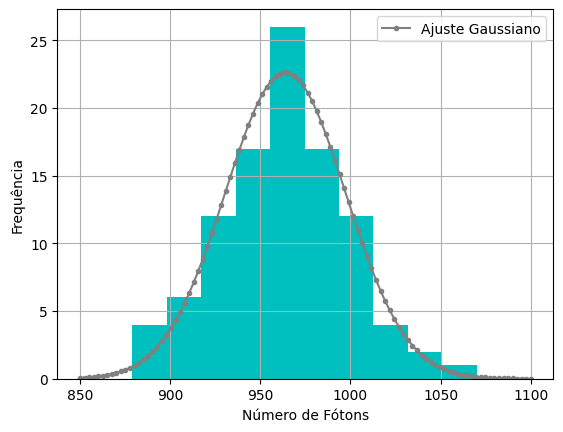

[  33.4156918   963.90707483 1894.63185819] 
 [[ 5.83138820e+00 -2.74631640e-02  1.65607020e+02]
 [-2.74631640e-02  5.76292027e+00 -8.81977176e-01]
 [ 1.65607020e+02 -8.81977176e-01  1.39498650e+04]]
33.41569179574302
31.028571949539067


In [346]:
def gaussB(x, a, b, N):
    return N*(1/(a*(2*math.pi)**(1/2)))*np.exp((-(x-b)**2/(2*a**2)))

Nbins = int(math.sqrt(mean(hs['B']))/3)



ListaOrdHist = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
LarguraBarra = (max(hs['B']) - min(hs['B']))/10
ListaAbsHist = []

for i in range(10):
    for j in range(len(hs['B'])):
        if min(hs['B']) + i*LarguraBarra  <= hs['B'][j] <= min(hs['B']) + (i+1)*LarguraBarra:
            ListaOrdHist[i] = ListaOrdHist[i] + 1
    ListaAbsHist = ListaAbsHist + [min(hs['B']) + LarguraBarra*i + LarguraBarra/2]


poptHist, pcovHist = curve_fit(gaussB, ListaAbsHist, ListaOrdHist, bounds=([10, 930, 0], [60, 1000, 5000])) #a, b, N

rgBL2 = np.linspace(850, 1100, 100)


plt.hist(hs['B'], bins=Nbins, color='c')
plt.plot(rgBL2, gaussB(rgBL2, *poptHist), marker = '.', color = 'Gray', label='Ajuste Gaussiano')
plt.legend()
plt.xlabel('Número de Fótons')
plt.ylabel('Frequência')
plt.grid()
plt.show()

print(poptHist,'\n', pcovHist)

SigmaHist = poptHist[0]
print(SigmaHist)
print(mean(hs['B'])**(1/2))


Caracterização do tempo morto 

Parâmetro a: 2777.563298298777 
Incerteza Parâmetro a: 92.42545341720313 
Parâmetro b: 26.792354455752843 
Incerteza Parâmetro b: 17.169613601657556


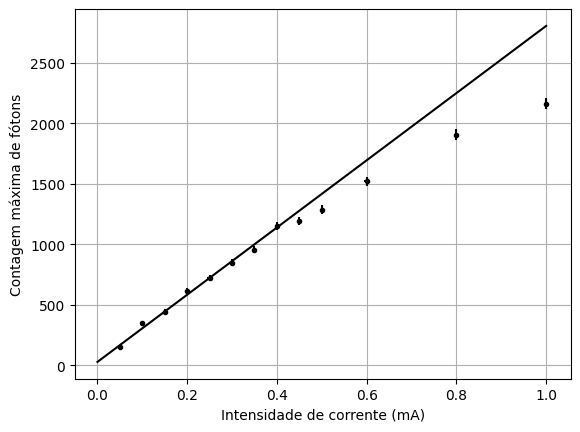

Parâmetro a: 0.0003388149522386391 
Incerteza Parâmetro a: 3.716546480435374e-06 
Parâmetro b (TEMPO MORTO): 2.2951543992473793e-05 
Incerteza Parâmetro b (TEMPO MORTO): 6.920137598145366e-06


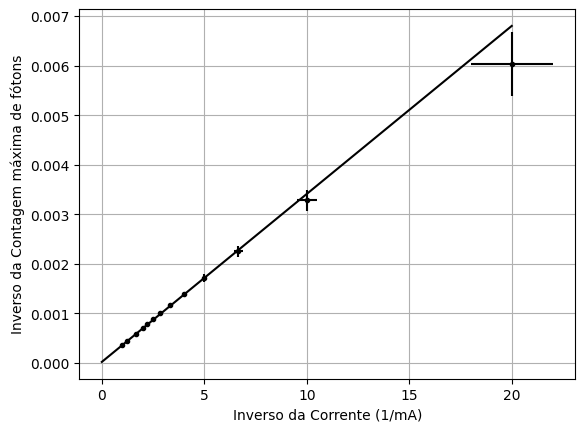

"\n# R = a*x + b, sendo que a e b são os parametros ajustados pela função ajusteTempoMorto(x,a,b)\n\ndef ajusteTempoMorto2(x,t):\n    return((poptTM[0]*x+poptTM[1])/((poptTM[0]*x+poptTM[1])*t+1))\n\npoptTM3, pcovTM3 = curve_fit(ajusteTempoMorto2, tmAjuste1['A'], tmAjuste1['B'], bounds=([0.00001], [0.001]))\n\nplt.errorbar(tm['A'], tm['B'], tm['C'], tm['D'], '.k')\nplt.plot(x1,ajusteTempoMorto2(x1,*poptTM3), 'k')\nplt.xlabel('Intensidade de corrente (mA)')\nplt.ylabel('Contagem máxima de fótons')\nplt.grid()\nplt.show()\n\nprint('Parâmetro t:', poptTM3[0])"

In [347]:
tm['C'] = np.sqrt(tm['B'])
tm['D'] = 0.005

def ajusteTempoMorto(x,a,b):
    return a*x + b

def ajusteTempoMorto2(R,t):
    return(R/(R*t+1))


tmAjuste1 = tm.query('0 <= A <= 0.4')


poptTM, pcovTM = curve_fit(ajusteTempoMorto, tmAjuste1['A'], tmAjuste1['B'], sigma=tmAjuste1['C'])

print('Parâmetro a:', poptTM[0], '\nIncerteza Parâmetro a:', np.sqrt(pcovTM[0][0]) ,'\nParâmetro b:', poptTM[1], '\nIncerteza Parâmetro b:', np.sqrt(pcovTM[1][1]))

x1 = np.linspace(0,1,200)

plt.errorbar(tm['A'], tm['B'], tm['C'], tm['D'], '.k')
plt.plot(x1,ajusteTempoMorto(x1,poptTM[0],poptTM[1]), 'k')
plt.xlabel('Intensidade de corrente (mA)')
plt.ylabel('Contagem máxima de fótons')
plt.grid()
plt.show()

tm['E'] = 1/tm['A']
tm['F'] = 1/ajusteTempoMorto(tm['A'],poptTM[0],poptTM[1])
tm['G'] = tm['F']**2 * np.sqrt((tm['A'])**2 * pcovTM[0][0] + pcovTM[1][1])
tm['H'] = tm['E']**2 * tm['D']

poptTM2, pcovTM2 = curve_fit(ajusteTempoMorto, tm['E'], tm['F'], sigma=tm['G'])
print('Parâmetro a:', poptTM2[0], '\nIncerteza Parâmetro a:', np.sqrt(pcovTM2[0][0]) ,'\nParâmetro b (TEMPO MORTO):', poptTM2[1], '\nIncerteza Parâmetro b (TEMPO MORTO):', np.sqrt(pcovTM2[1][1]))

x2 = np.linspace(0,20,200)

plt.errorbar(tm['E'], tm['F'], tm['G'], tm['H'], '.k')
plt.plot(x2,ajusteTempoMorto(x2,poptTM2[0],poptTM2[1]), 'k')
plt.xlabel("Inverso da Corrente (1/mA)")
plt.ylabel("Inverso da Contagem máxima de fótons")
plt.grid()
plt.show()

df['B'] = df['B']/(1-(pcovTM2[1][1]*df['B']))
df['C'] = df['C']/(1-(pcovTM2[1][1]*df['C']))
df['D'] = df['D']/(1-(pcovTM2[1][1]*df['D']))
df['E'] = df['E']/(1-(pcovTM2[1][1]*df['E']))
df['F'] = df['F']/(1-(pcovTM2[1][1]*df['F']))

TempoMorto = poptTM2[1]
SigmaTMorto = np.sqrt(pcovTM2[1][1])


'''
# R = a*x + b, sendo que a e b são os parametros ajustados pela função ajusteTempoMorto(x,a,b)

def ajusteTempoMorto2(x,t):
    return((poptTM[0]*x+poptTM[1])/((poptTM[0]*x+poptTM[1])*t+1))

poptTM3, pcovTM3 = curve_fit(ajusteTempoMorto2, tmAjuste1['A'], tmAjuste1['B'], bounds=([0.00001], [0.001]))

plt.errorbar(tm['A'], tm['B'], tm['C'], tm['D'], '.k')
plt.plot(x1,ajusteTempoMorto2(x1,*poptTM3), 'k')
plt.xlabel('Intensidade de corrente (mA)')
plt.ylabel('Contagem máxima de fótons')
plt.grid()
plt.show()

print('Parâmetro t:', poptTM3[0])'''




Plot 35KV, 30KV, 28KV, 25KV, 18KV

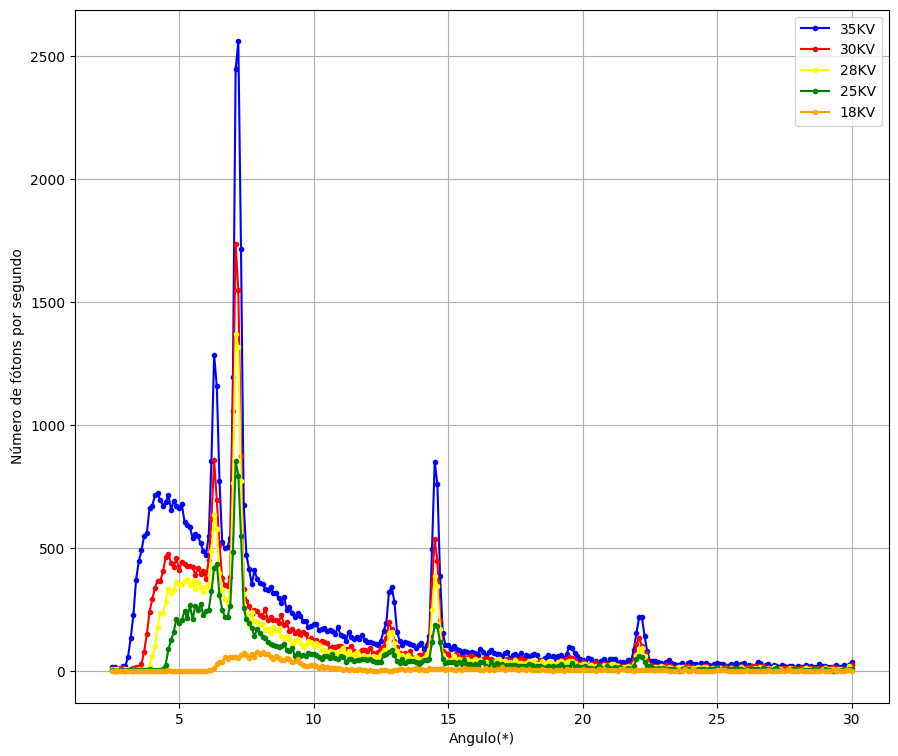

In [348]:
plt.figure(figsize=(10.5, 9))

plt.plot(df['A'], df['B'], label='35KV', marker='.', color='Blue')
plt.plot(df['A'], df['C'], label='30KV', marker='.', color='Red')
plt.plot(df['A'], df['D'], label='28KV', marker='.', color='Yellow')
plt.plot(df['A'], df['E'], label='25KV', marker='.', color='Green')
plt.plot(df['A'], df['F'], label='18KV', marker='.', color='Orange')
plt.xlabel('Angulo(*)')
plt.ylabel('Número de fótons por segundo')
plt.grid()
plt.legend()
plt.show()

Calculo de I_a / I_b == n_a / n_b pela hipótese de planck, e posterior análise de picos

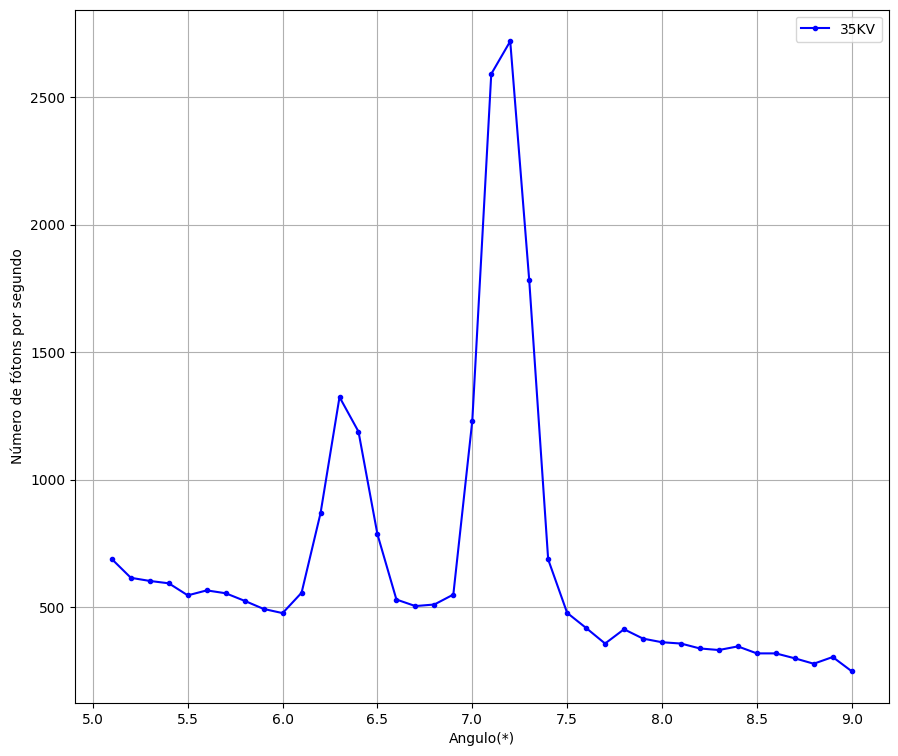

Para o pico alfa : 
 a =  0.015113725667119226 
 b =  7.168155657280462 
 N =  2560.2650800831925 
 c =  299.99999999999994 
 Matriz de covariancia : 
 [[ 5.39326376e-06 -2.05731656e-08  1.71176170e-02 -1.98658579e-01]
 [-2.05731656e-08  3.38383610e-05 -4.15246392e-02  2.12484337e-02]
 [ 1.71176170e-02 -4.15246392e-02  1.91539173e+04 -5.03949802e+03]
 [-1.98658579e-01  2.12484337e-02 -5.03949802e+03  9.73106905e+03]] 
 Ajuste do pico alfa já considerando incertezas :


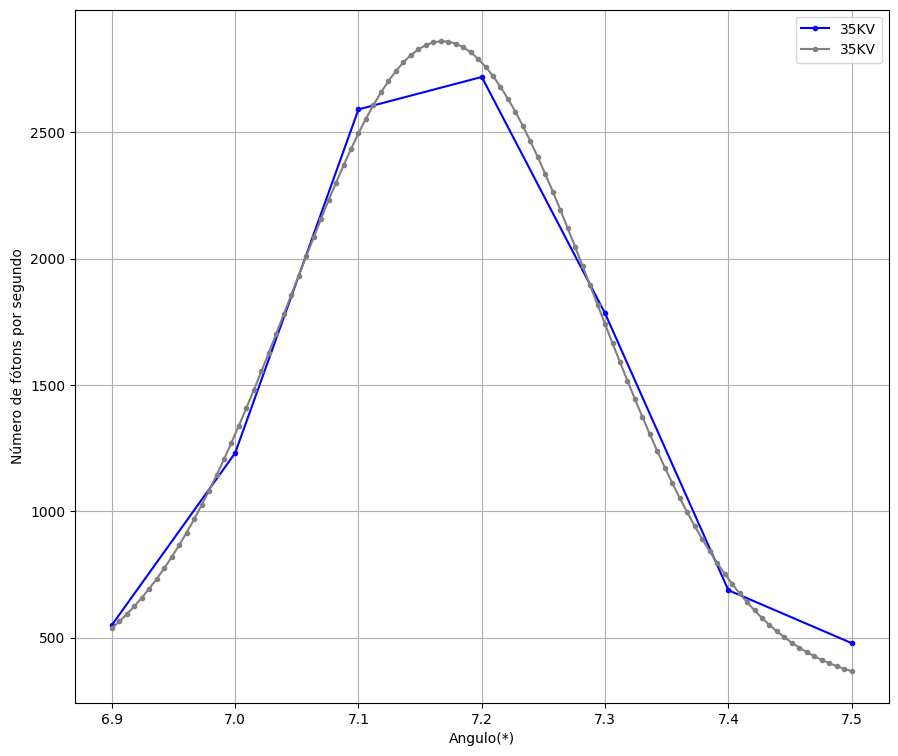

Para o pico Beta : 
 a =  0.023411506706496516 
 b =  6.335158816352252 
 N =  958.2892785438924 
 c =  299.99999999999994 
 Matriz de covariancia : 
 [[ 1.07541195e-04 -1.59686368e-05  8.81174764e-01 -1.49583953e+00]
 [-1.59686368e-05  1.95729314e-04 -2.75921969e-01  3.18099013e-01]
 [ 8.81174764e-01 -2.75921969e-01  2.19660289e+04 -1.81418426e+04]
 [-1.49583953e+00  3.18099013e-01 -1.81418426e+04  2.44466889e+04]] 
 Ajuste do pico beta já considerando incertezas :


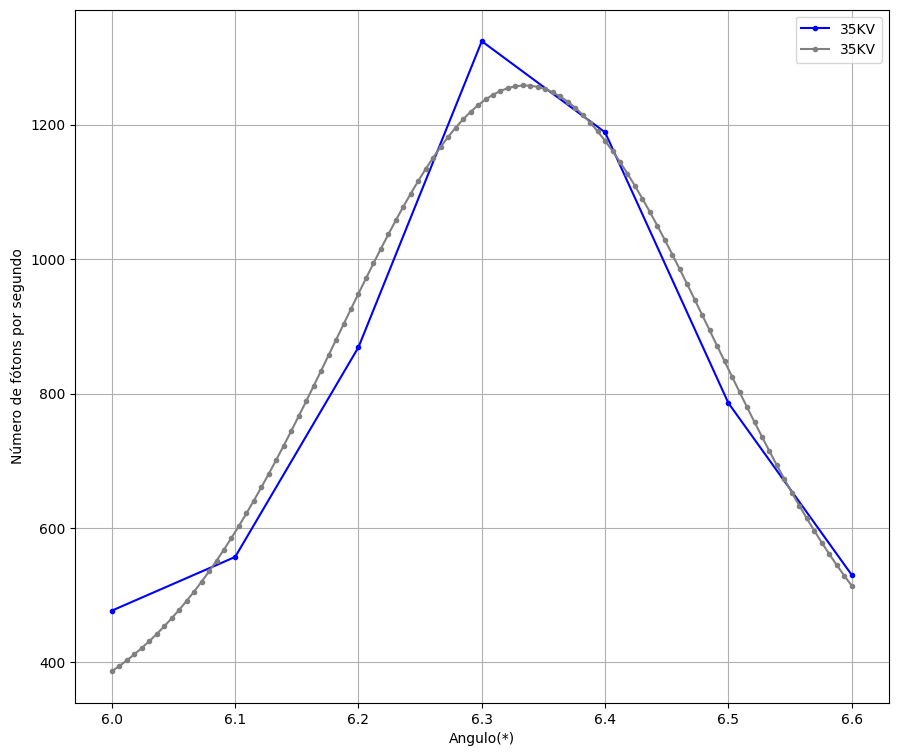

Razão [2.2731379253212154, 0.41196354299179877]


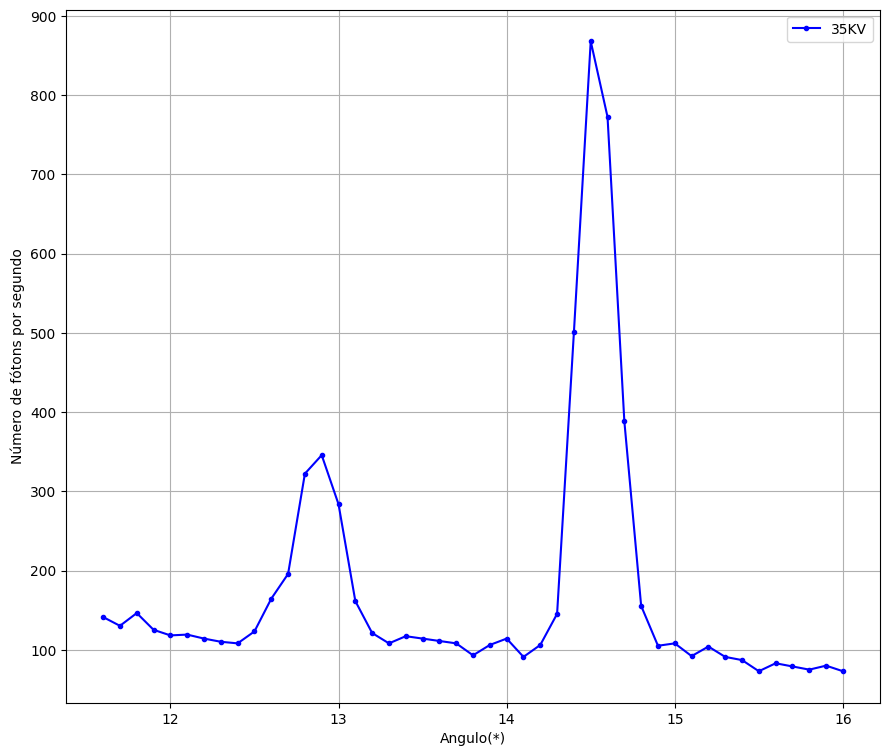

Para o pico alfa : 
 a =  0.012206851365219009 
 b =  14.538777883645054 
 N =  818.3546763099264 
 c =  94.03989715683181 
 Matriz de covariancia : 
 [[ 1.81449071e-06 -1.05242406e-07 -1.40447980e-02 -1.49870749e-02]
 [-1.05242406e-07  2.68690022e-05 -1.11166628e-02  7.51614026e-03]
 [-1.40447980e-02 -1.11166628e-02  1.42275872e+03 -1.11751518e+02]
 [-1.49870749e-02  7.51614026e-03 -1.11751518e+02  2.60337742e+02]] 
 Ajuste do pico alfa já considerando incertezas :


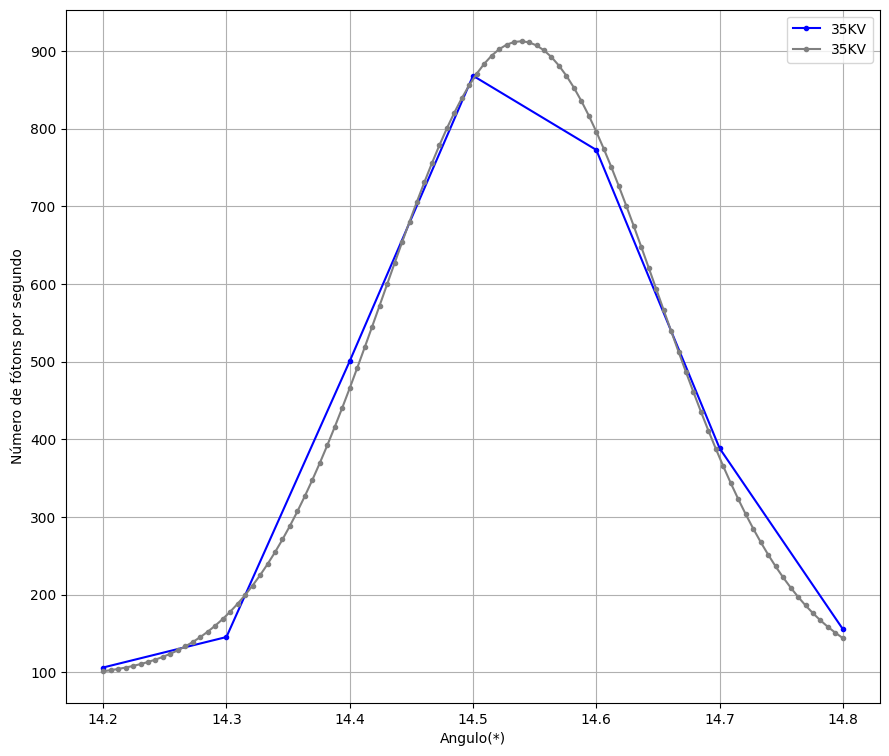

Para o pico Beta : 
 a =  0.01568603766966014 
 b =  12.877249729110614 
 N =  236.1609415846766 
 c =  121.64734481742639 
 Matriz de covariancia : 
 [[ 2.28437532e-05  3.24301188e-06  2.00791292e-02 -8.13452243e-02]
 [ 3.24301188e-06  1.28599851e-04  1.25978342e-02 -1.61999545e-02]
 [ 2.00791292e-02  1.25978342e-02  6.09329040e+02 -2.64913908e+02]
 [-8.13452243e-02 -1.61999545e-02 -2.64913908e+02  4.12239703e+02]] 
 Ajuste do pico beta já considerando incertezas :


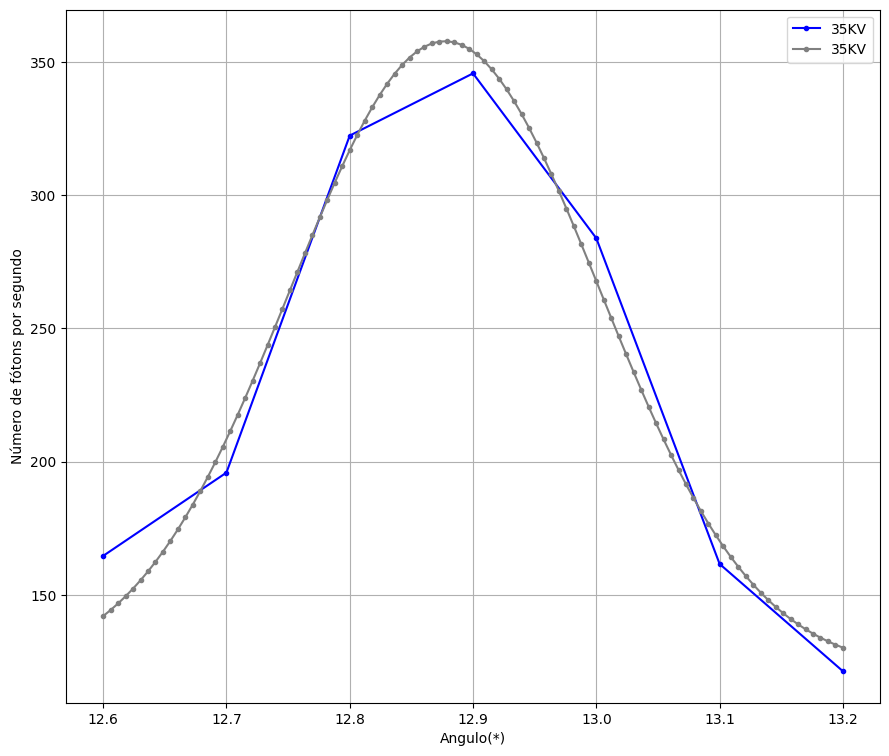

Razão [2.549953727011828, 0.25501019112647805]


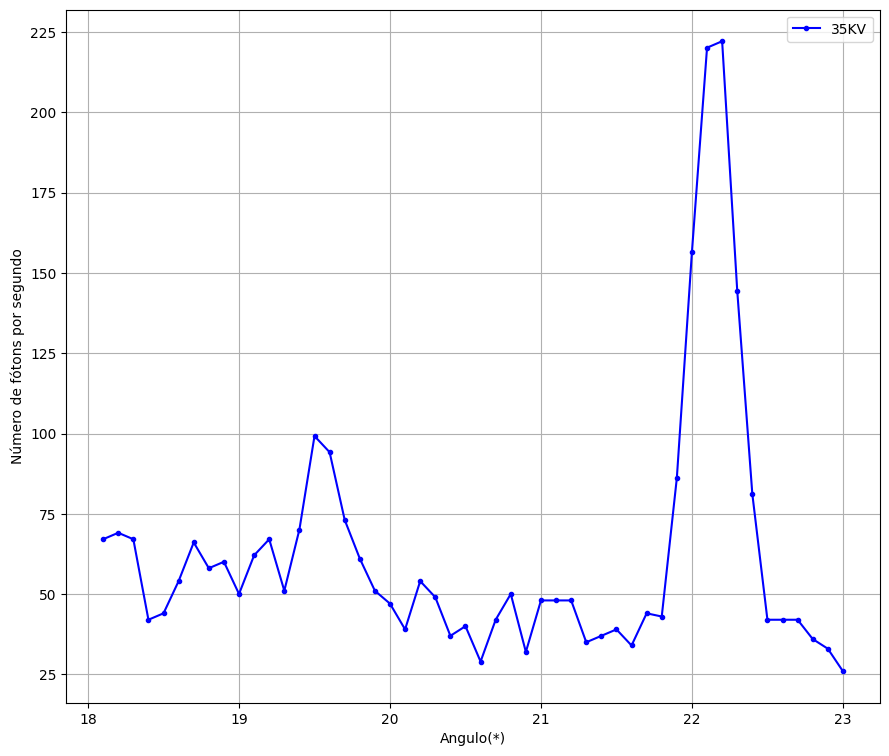

Para o pico alfa : 
 a =  0.023376318495209904 
 b =  22.14445970286817 
 N =  200.73527111506235 
 c =  29.293101232601586 
 Matriz de covariancia : 
 [[ 2.42345181e-06  4.99450395e-07  2.54644378e-03 -6.03871916e-03]
 [ 4.99450395e-07  6.76129975e-06  2.12840281e-03 -2.33533044e-03]
 [ 2.54644378e-03  2.12840281e-03  2.16817608e+01 -1.33548878e+01]
 [-6.03871916e-03 -2.33533044e-03 -1.33548878e+01  1.93800526e+01]] 
 Ajuste do pico alfa já considerando incertezas :


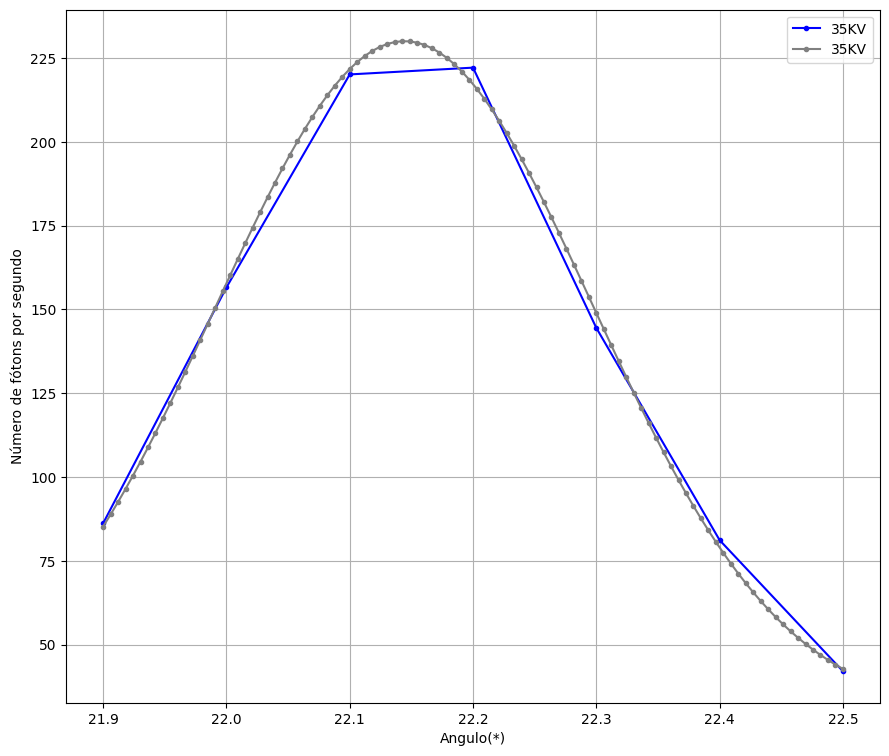

Para o pico Beta : 
 a =  0.00828273761282367 
 b =  19.55099557360826 
 N =  44.36192779971834 
 c =  58.84277802213916 
 Matriz de covariancia : 
 [[ 2.17965534e-05  8.26832565e-07 -9.36862234e-03 -1.58139748e-02]
 [ 8.26832565e-07  4.05662201e-04 -4.50666842e-03  7.10103249e-04]
 [-9.36862234e-03 -4.50666842e-03  9.34140092e+01 -1.63440171e+01]
 [-1.58139748e-02  7.10103249e-04 -1.63440171e+01  2.68854556e+01]] 
 Ajuste do pico beta já considerando incertezas :


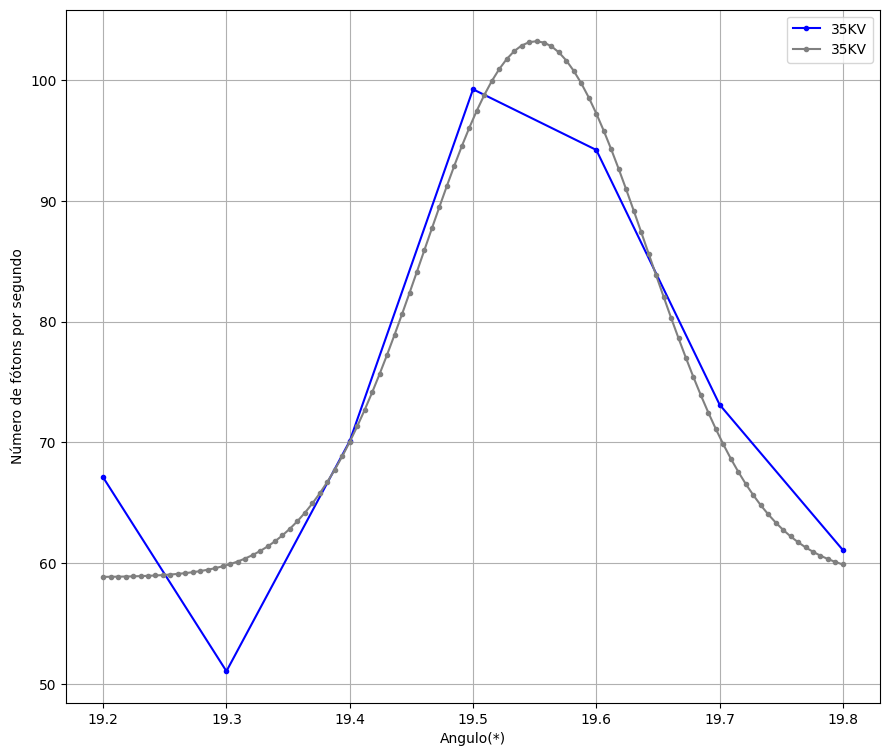

Razão [2.22885546270262, 0.24487468484917138]


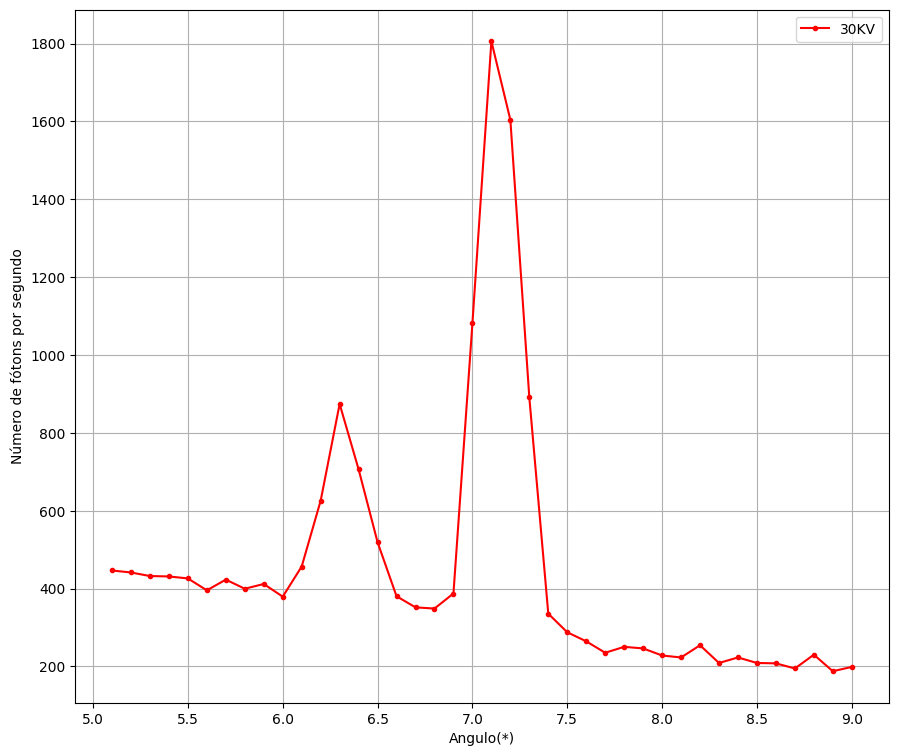

Para o pico alfa : 
 a =  0.011813811678914793 
 b =  7.137769370933958 
 N =  1595.0289962385593 
 c =  299.99999999999994 
 Matriz de covariancia : 
 [[ 3.51035672e-06  1.47903661e-08 -4.88493082e-02 -5.80656693e-02]
 [ 1.47903661e-08  5.32371844e-05 -4.75838329e-02  2.76289949e-02]
 [-4.88493082e-02 -4.75838329e-02  1.03391178e+04 -9.82722423e+02]
 [-5.80656693e-02  2.76289949e-02 -9.82722423e+02  2.07521290e+03]] 
 Ajuste do pico alfa já considerando incertezas :


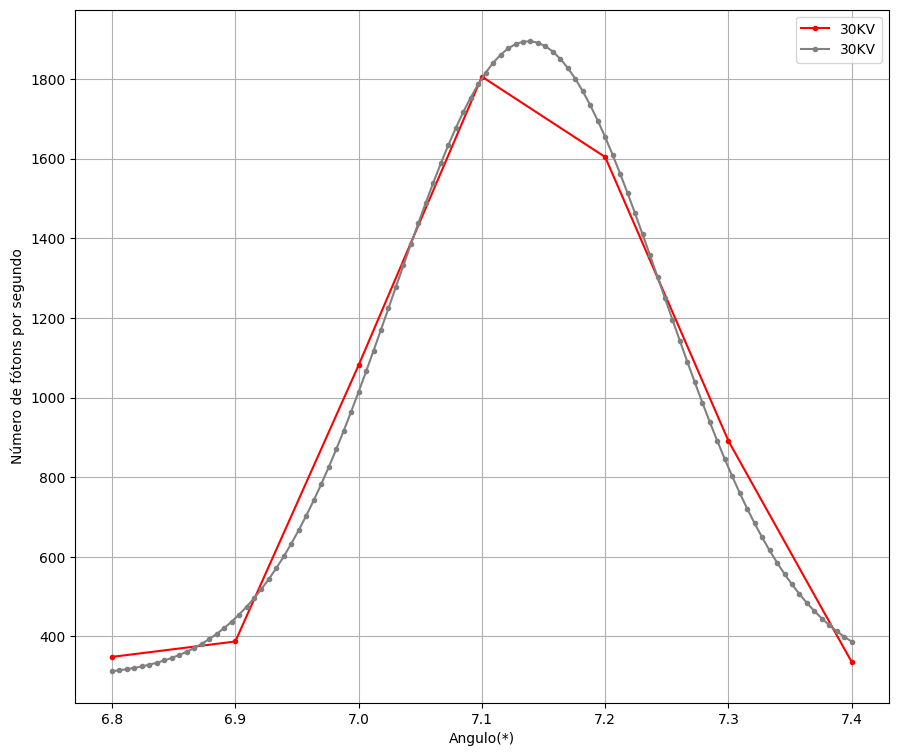

Para o pico Beta : 
 a =  0.02030254068223141 
 b =  6.316201635342563 
 N =  515.1482207315391 
 c =  299.99999999999994 
 Matriz de covariancia : 
 [[ 6.26125121e-05 -2.86133899e-06  2.79524800e-01 -5.04922518e-01]
 [-2.86133899e-06  1.39896069e-04 -2.95749056e-02  3.44133799e-02]
 [ 2.79524800e-01 -2.95749056e-02  4.36564847e+03 -3.50414892e+03]
 [-5.04922518e-01  3.44133799e-02 -3.50414892e+03  4.87301931e+03]] 
 Ajuste do pico beta já considerando incertezas :


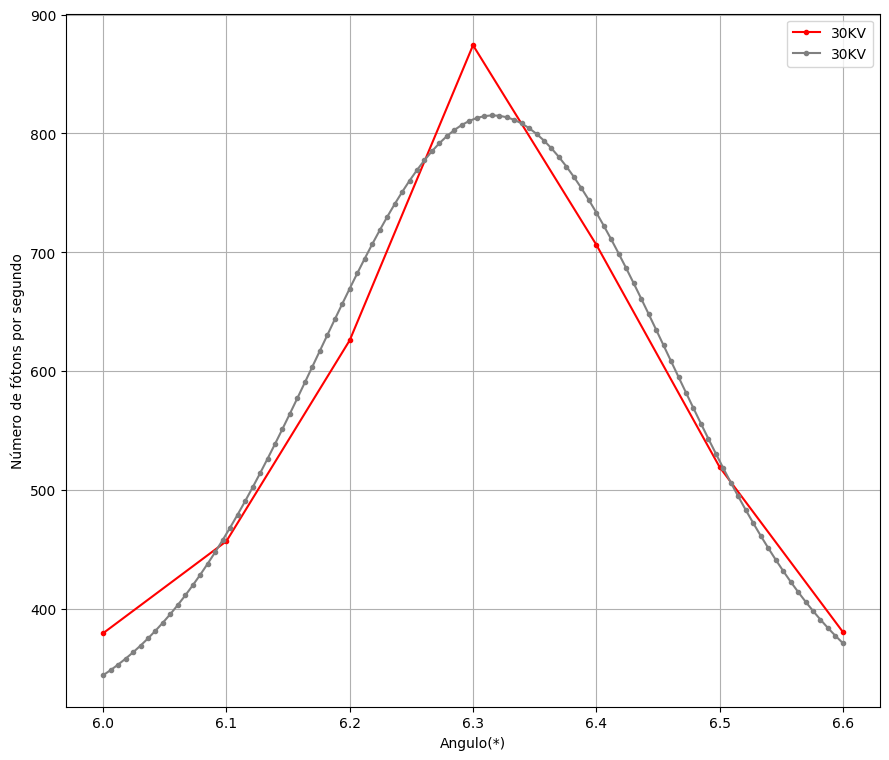

Razão [2.3247661566848565, 0.30631229880982613]


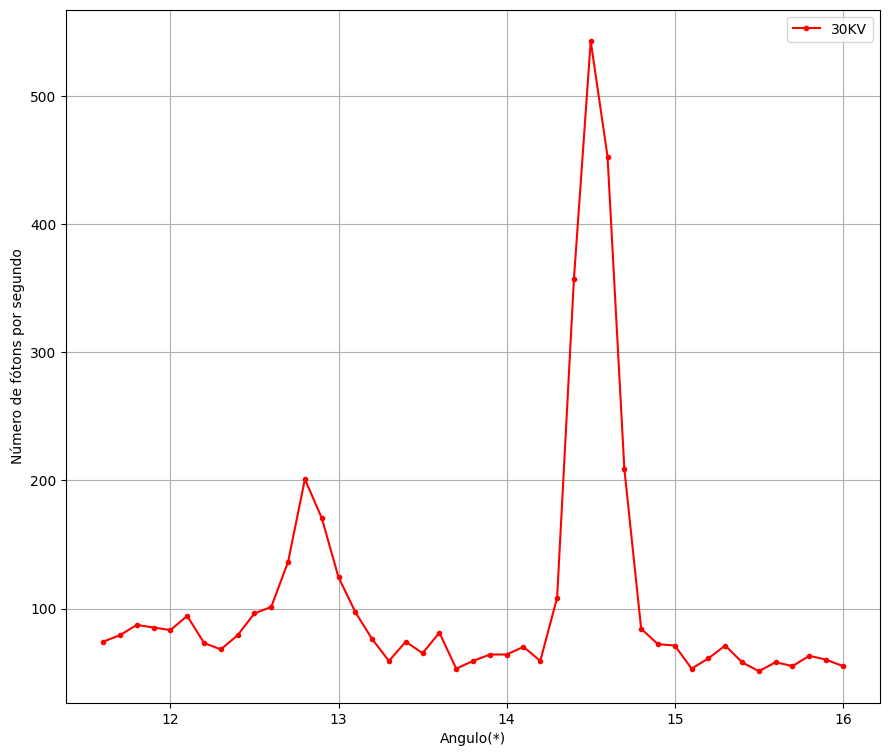

Para o pico alfa : 
 a =  0.013032363186985365 
 b =  14.524377804045729 
 N =  511.04488985910535 
 c =  49.35985069490769 
 Matriz de covariancia : 
 [[ 1.64450018e-06 -1.56244495e-07 -6.07855759e-03 -9.33028979e-03]
 [-1.56244495e-07  1.97520289e-05 -4.75419990e-03  3.79478822e-03]
 [-6.07855759e-03 -4.75419990e-03  4.18880548e+02 -3.83552522e+01]
 [-9.33028979e-03  3.79478822e-03 -3.83552522e+01  9.49523539e+01]] 
 Ajuste do pico alfa já considerando incertezas :


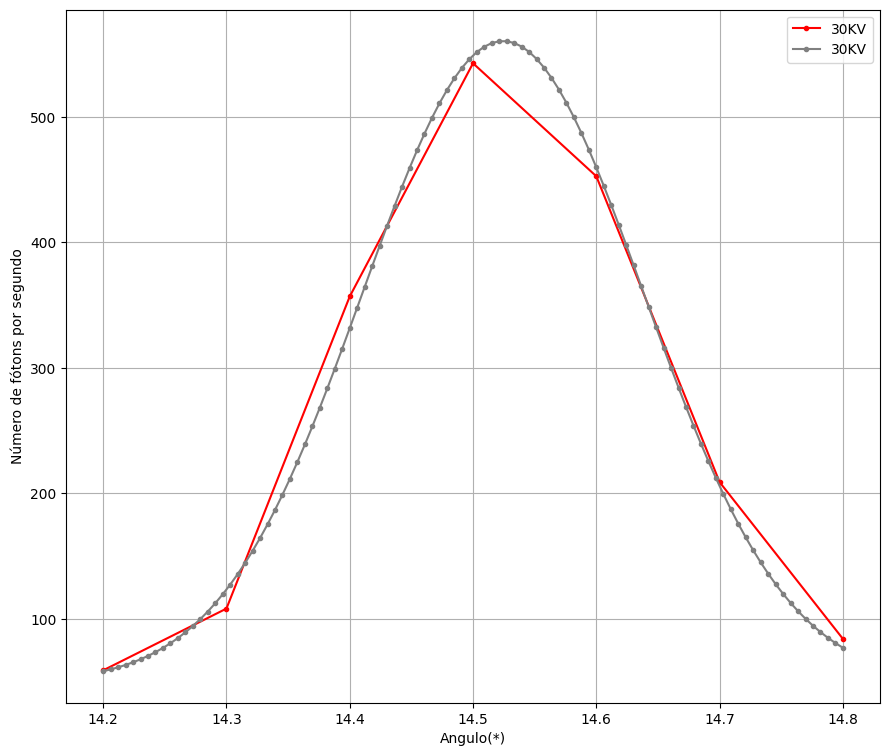

Para o pico Beta : 
 a =  0.009541139308863087 
 b =  12.830077969309054 
 N =  104.63063241761358 
 c =  95.76583636586878 
 Matriz de covariancia : 
 [[ 2.16705241e-06  1.46905008e-07 -1.74767719e-03 -3.48916267e-03]
 [ 1.46905008e-07  3.34639312e-05 -6.70029851e-04 -5.06885237e-05]
 [-1.74767719e-03 -6.70029851e-04  3.97275471e+01 -7.21557138e+00]
 [-3.48916267e-03 -5.06885237e-05 -7.21557138e+00  1.21547850e+01]] 
 Ajuste do pico beta já considerando incertezas :


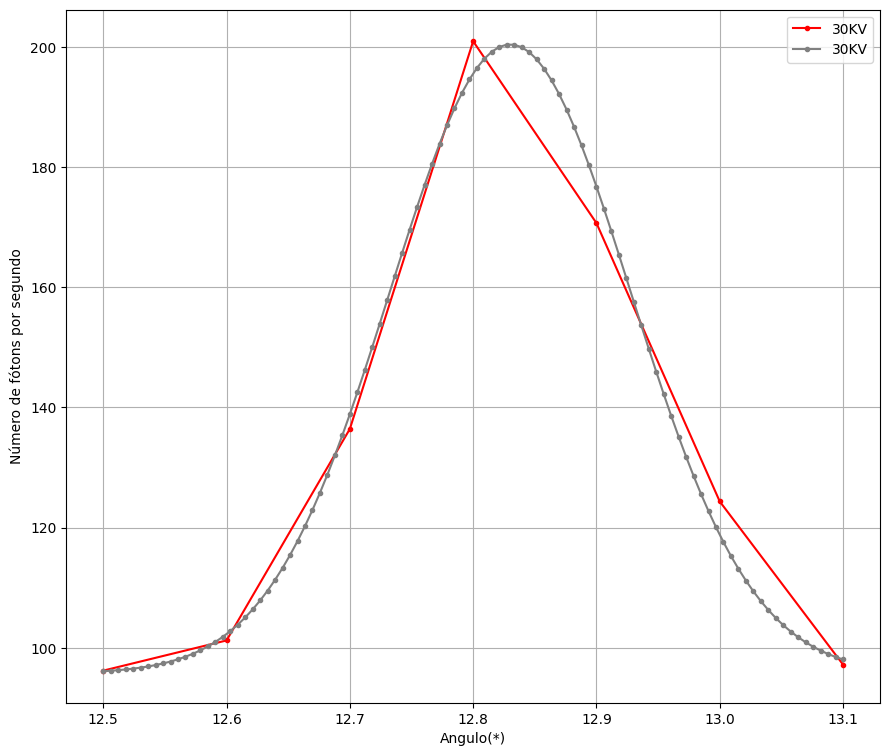

Razão [2.7964801174191365, 0.15132195551799704]


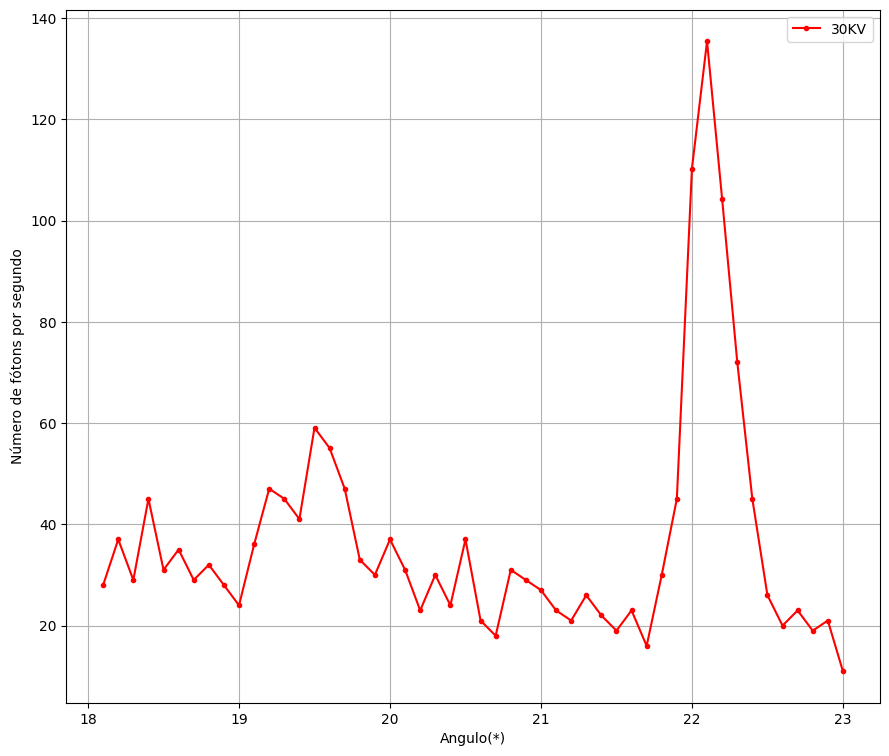

Para o pico alfa : 
 a =  0.01787471060083752 
 b =  22.12141730983422 
 N =  107.13561207850495 
 c =  25.78736685292784 
 Matriz de covariancia : 
 [[ 4.80692328e-05 -2.90148120e-06  2.34170744e-02 -7.45116179e-02]
 [-2.90148120e-06  1.92127043e-04 -1.94594473e-02  1.33212519e-02]
 [ 2.34170744e-02 -1.94594473e-02  1.92058979e+02 -9.36707332e+01]
 [-7.45116179e-02  1.33212519e-02 -9.36707332e+01  1.49911562e+02]] 
 Ajuste do pico alfa já considerando incertezas :


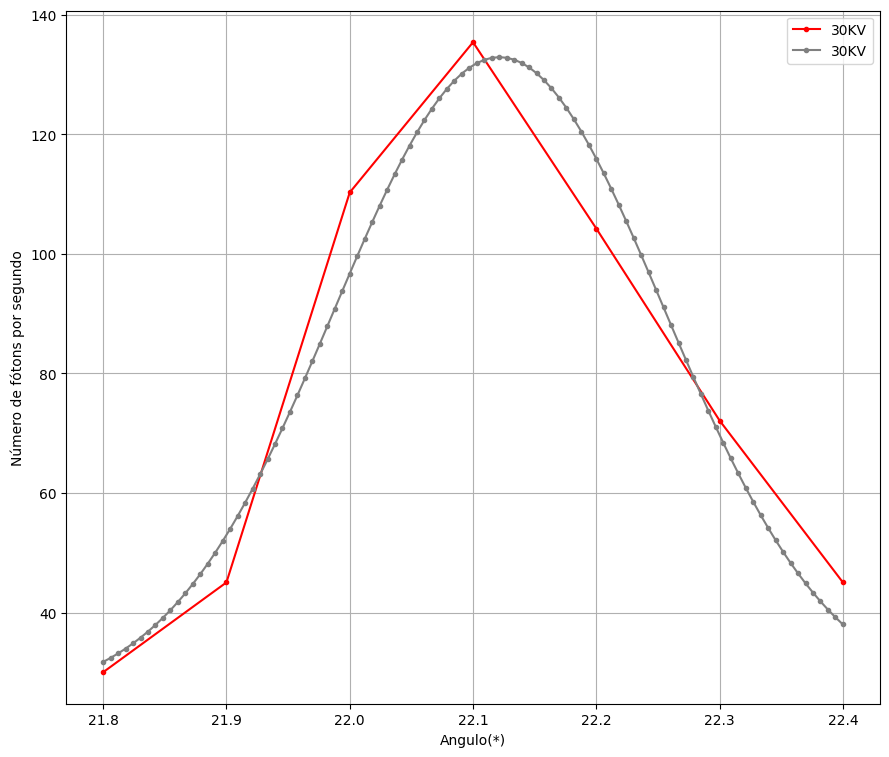

Para o pico Beta : 
 a =  0.15949215992811833 
 b =  19.470547582479796 
 N =  51.93390909176489 
 c =  4.258800854904412e-11 
 Matriz de covariancia : 
 [[ 5.72417017e+00  6.69784990e-02  1.57551946e+03 -1.58550820e+03]
 [ 6.69784990e-02  5.46196642e-03  1.93541114e+01 -1.93957777e+01]
 [ 1.57551946e+03  1.93541114e+01  4.34943852e+05 -4.37536520e+05]
 [-1.58550820e+03 -1.93957777e+01 -4.37536520e+05  4.40177666e+05]] 
 Ajuste do pico beta já considerando incertezas :


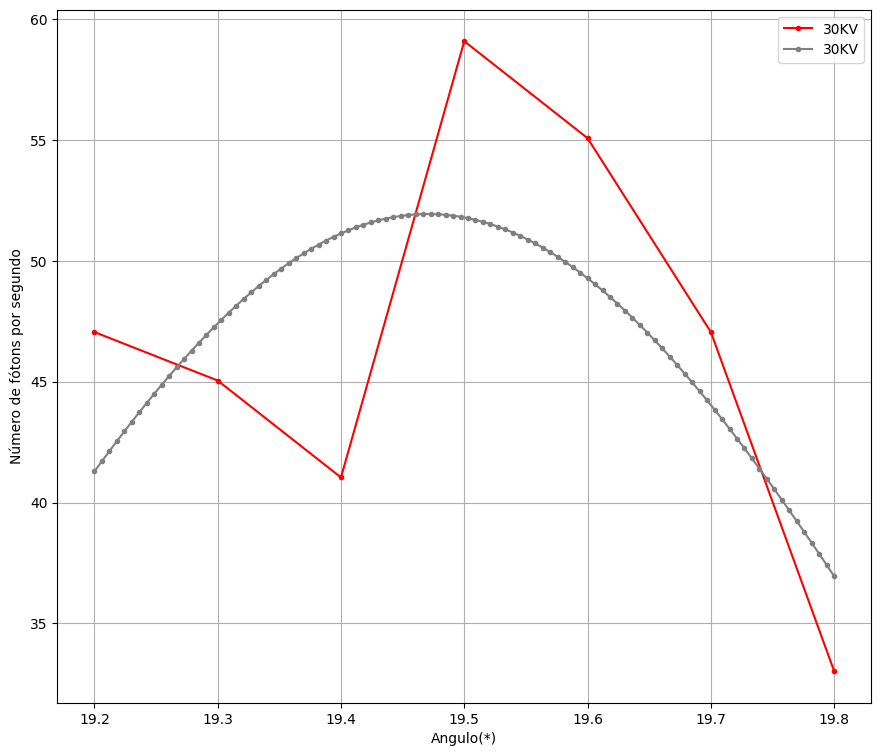

Razão [2.5594641585029705, 46.104697094053336]


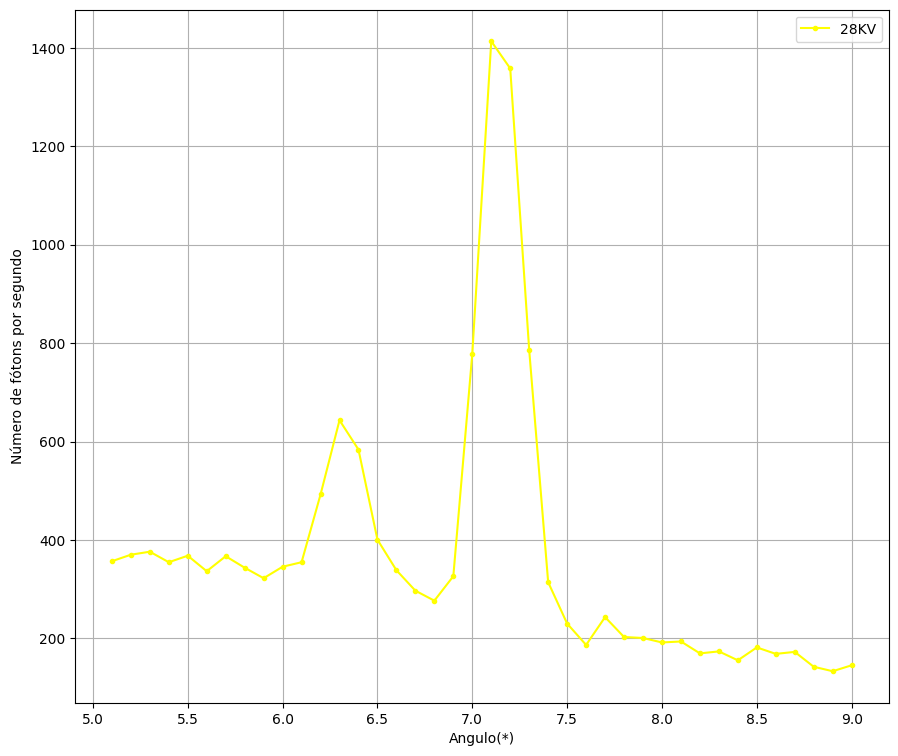

Para o pico alfa : 
 a =  0.011994981142617375 
 b =  7.14886772611283 
 N =  1267.5820986880522 
 c =  254.44521639924253 
 Matriz de covariancia : 
 [[ 1.34395215e-06  8.36911285e-08 -1.48080162e-02 -1.74341187e-02]
 [ 8.36911285e-08  1.98042331e-05 -1.30763523e-02  7.26521076e-03]
 [-1.48080162e-02 -1.30763523e-02  2.42580360e+03 -2.40958336e+02]
 [-1.74341187e-02  7.26521076e-03 -2.40958336e+02  4.97727288e+02]] 
 Ajuste do pico alfa já considerando incertezas :


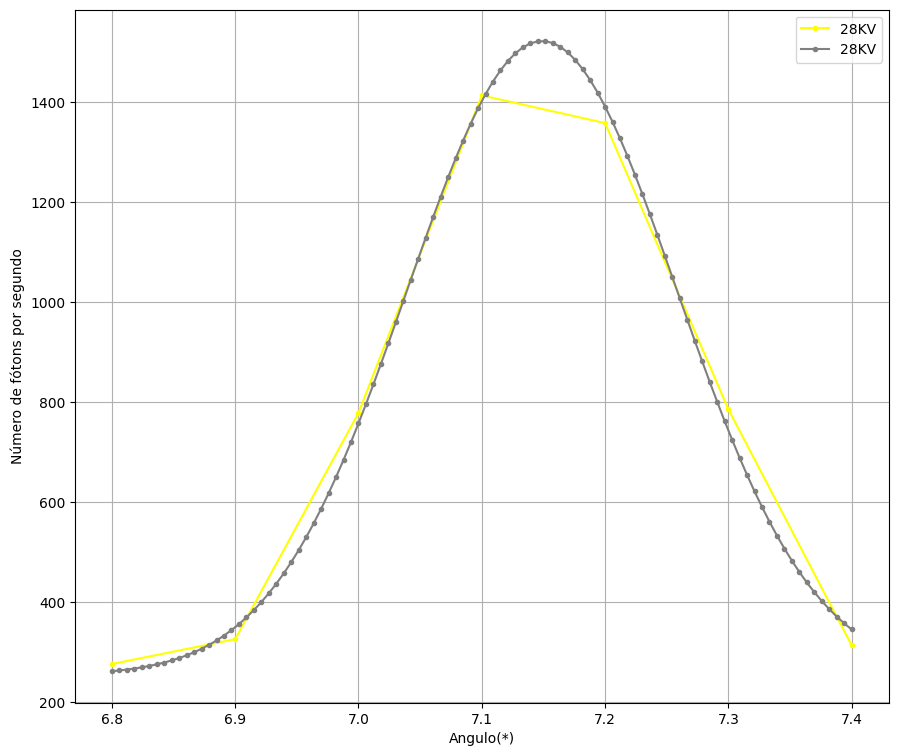

Para o pico Beta : 
 a =  0.014168903839072402 
 b =  6.323223889326588 
 N =  343.4692679605163 
 c =  299.99999999999994 
 Matriz de covariancia : 
 [[ 1.56978830e-05 -7.08352695e-07  1.91669039e-02 -8.69338568e-02]
 [-7.08352695e-07  1.03567409e-04 -3.28472573e-03  5.90087503e-03]
 [ 1.91669039e-02 -3.28472573e-03  1.10442192e+03 -4.72080768e+02]
 [-8.69338568e-02  5.90087503e-03 -4.72080768e+02  7.19494664e+02]] 
 Ajuste do pico beta já considerando incertezas :


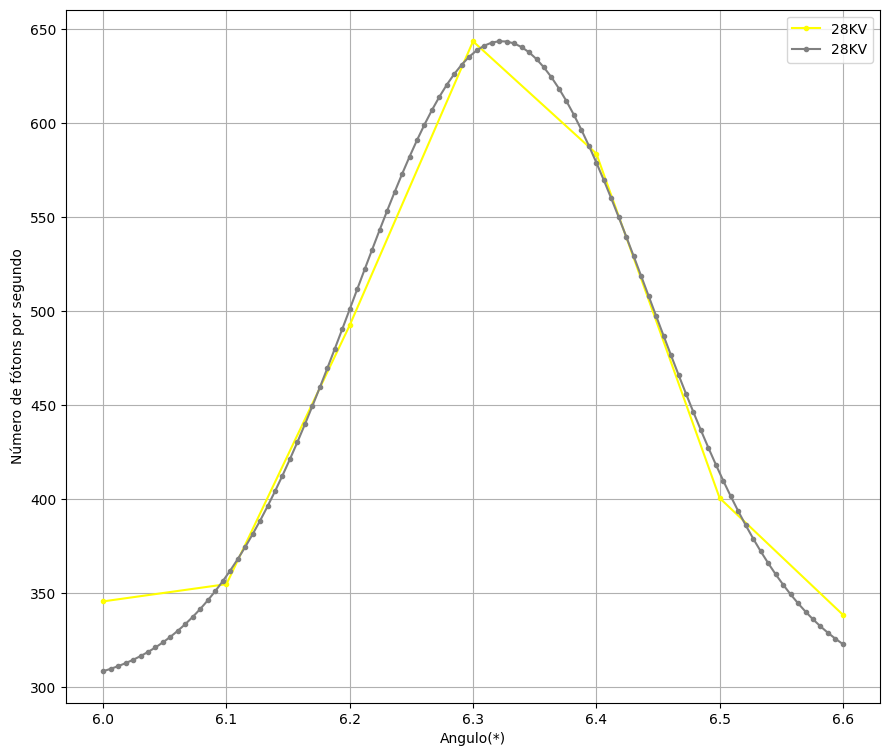

Razão [2.3653457762037013, 0.17806270336644778]


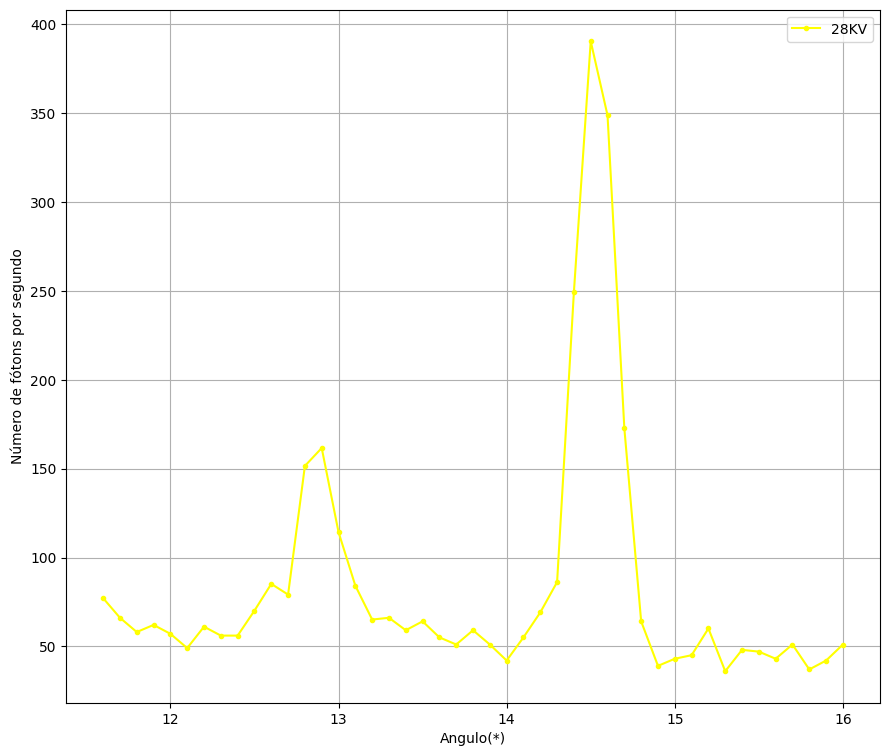

Para o pico alfa : 
 a =  0.012027348784830342 
 b =  14.530306982248367 
 N =  356.87581135882414 
 c =  56.92977514078162 
 Matriz de covariancia : 
 [[ 2.92198523e-06 -2.51671304e-08 -7.27262881e-03 -1.29657391e-02]
 [-2.51671304e-08  3.73266619e-05 -3.85519349e-03  2.79762882e-03]
 [-7.27262881e-03 -3.85519349e-03  4.19563388e+02 -4.81980337e+01]
 [-1.29657391e-02  2.79762882e-03 -4.81980337e+01  1.05098685e+02]] 
 Ajuste do pico alfa já considerando incertezas :


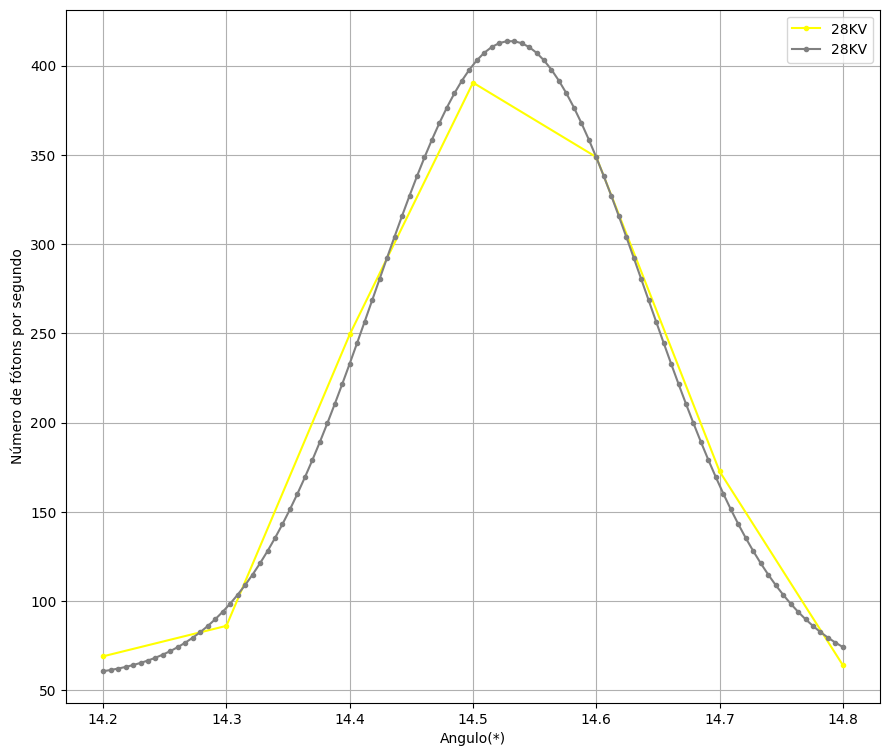

Para o pico Beta : 
 a =  0.008559054337643684 
 b =  12.876870642670292 
 N =  97.50838250258496 
 c =  72.86737165125507 
 Matriz de covariancia : 
 [[ 1.08636052e-05  1.01359886e-06 -1.21012580e-02 -1.62604619e-02]
 [ 1.01359886e-06  2.20035308e-04 -7.76015943e-03  4.55126844e-04]
 [-1.21012580e-02 -7.76015943e-03  2.44603564e+02 -3.56121897e+01]
 [-1.62604619e-02  4.55126844e-04 -3.56121897e+01  5.88561775e+01]] 
 Ajuste do pico beta já considerando incertezas :


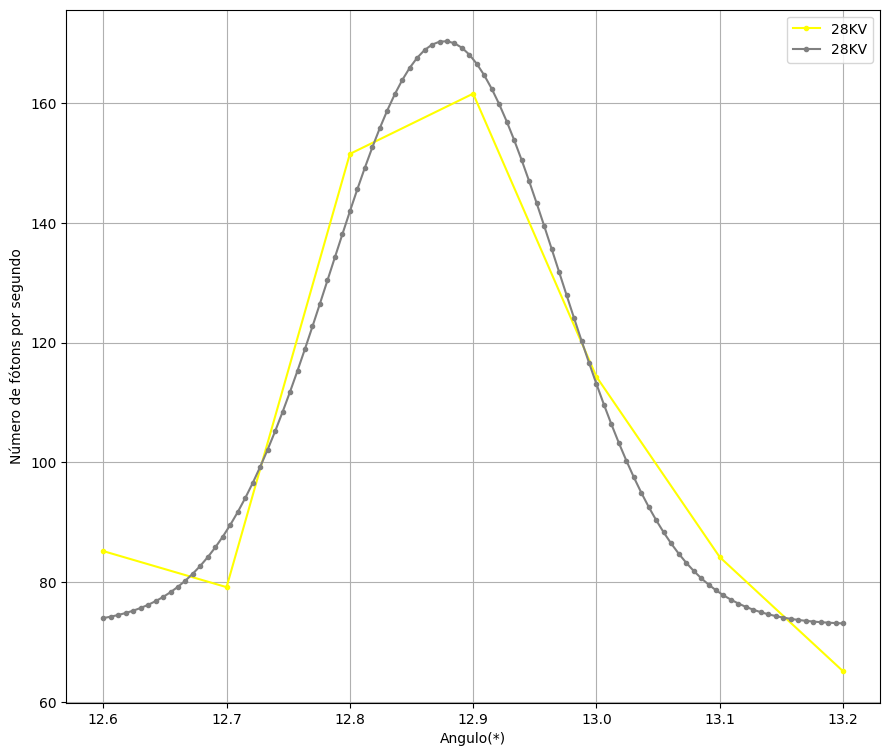

Razão [2.428782126627958, 0.282387675733326]


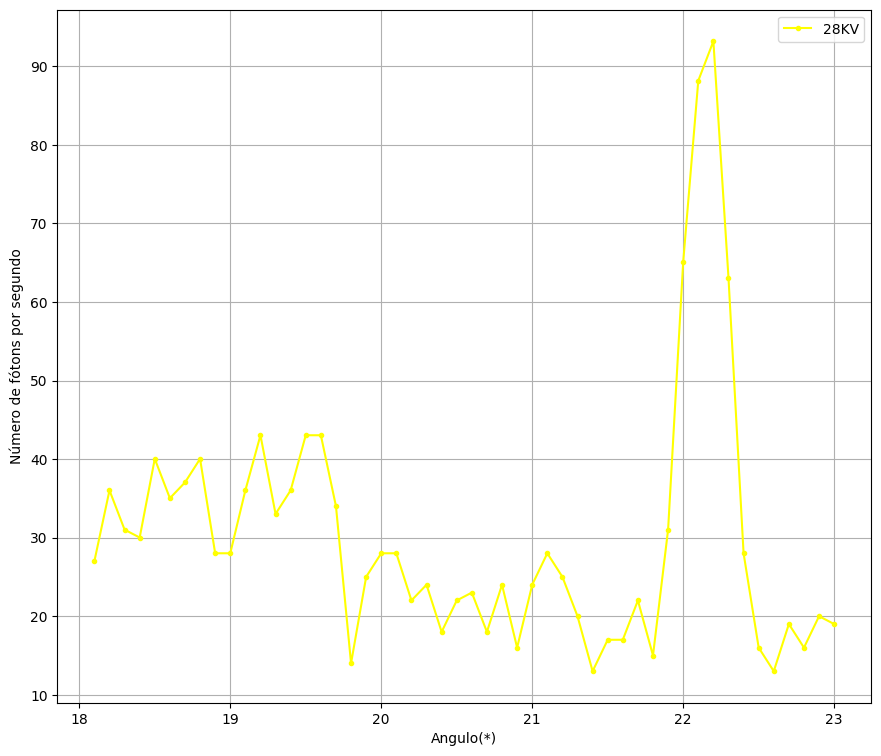

Para o pico alfa : 
 a =  0.021474384857060658 
 b =  22.147456968204647 
 N =  86.17203107434051 
 c =  10.612433783839363 
 Matriz de covariancia : 
 [[ 6.87656198e-06  1.37275452e-06  2.47076670e-03 -7.45089704e-03]
 [ 1.37275452e-06  2.42259910e-05  2.73841314e-03 -2.92938482e-03]
 [ 2.47076670e-03  2.73841314e-03  1.39831935e+01 -7.00592350e+00]
 [-7.45089704e-03 -2.92938482e-03 -7.00592350e+00  1.06529225e+01]] 
 Ajuste do pico alfa já considerando incertezas :


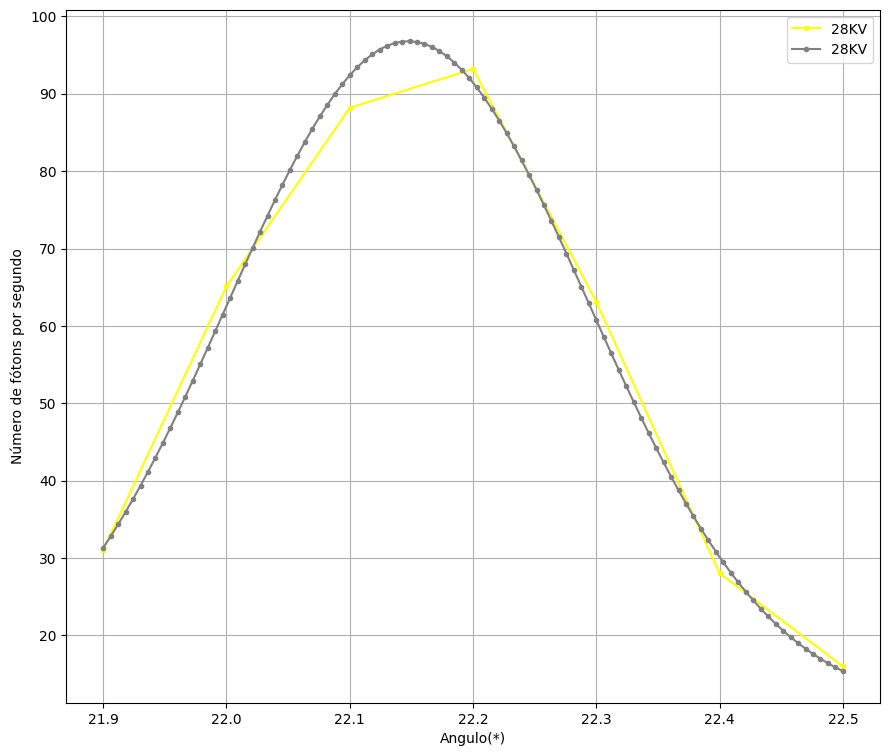

Para o pico Beta : 
 a =  0.021706170792456923 
 b =  19.499826503095626 
 N =  27.633896031207204 
 c =  17.551413184870587 
 Matriz de covariancia : 
 [[ 5.24150858e-04  2.84632503e-05  6.77609069e-02 -1.72725871e-01]
 [ 2.84632503e-05  2.11380003e-03  1.04620104e-01 -7.83744030e-02]
 [ 6.77609069e-02  1.04620104e-01  1.05931277e+02 -6.23329425e+01]
 [-1.72725871e-01 -7.83744030e-02 -6.23329425e+01  8.40545190e+01]] 
 Ajuste do pico beta já considerando incertezas :


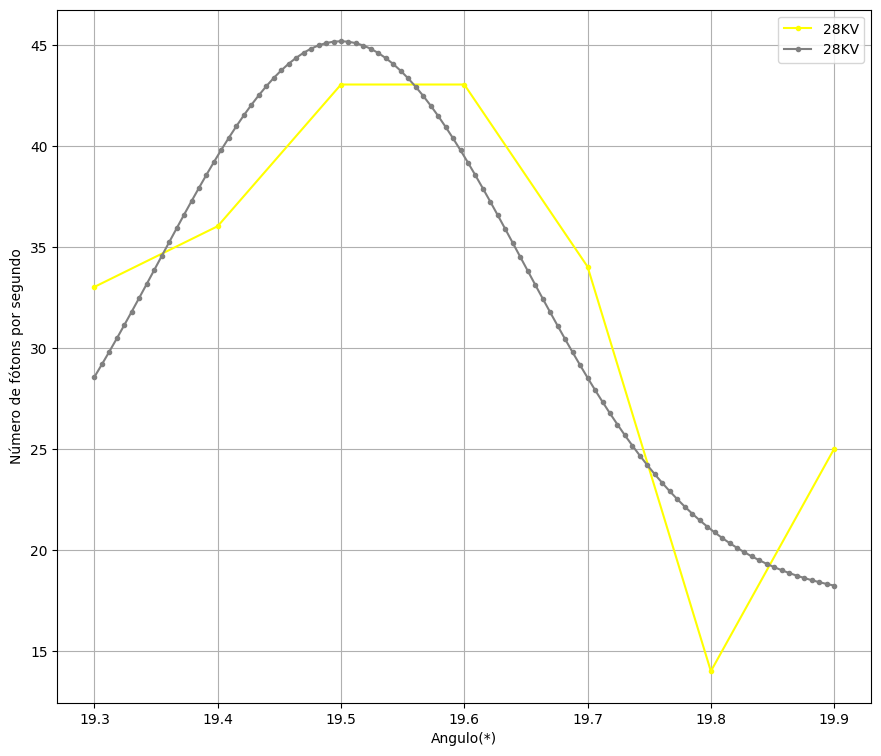

Razão [2.1419453919271203, 0.6625581906123832]


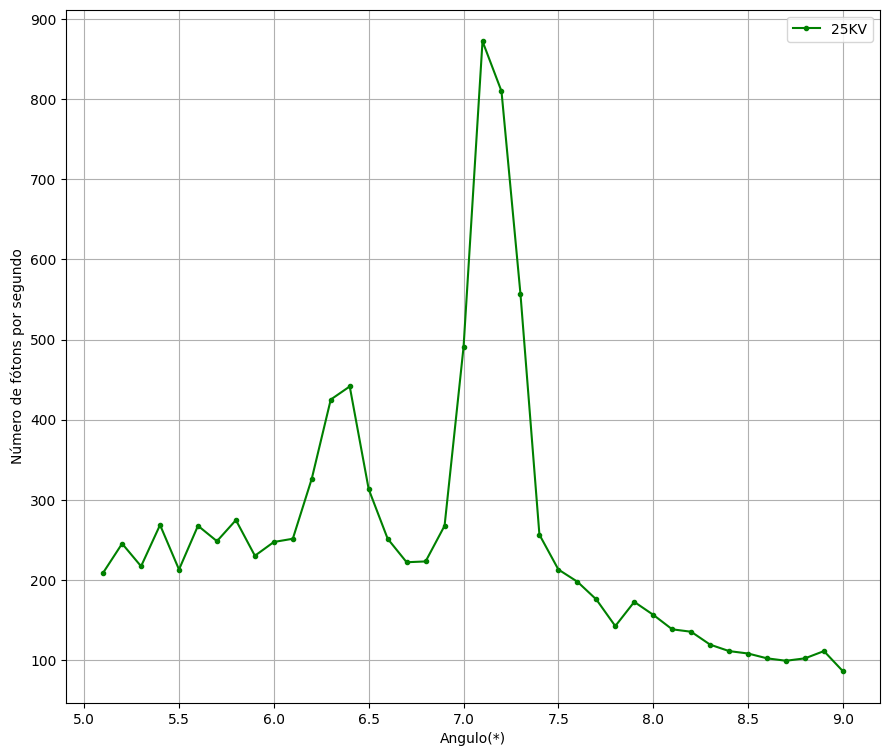

Para o pico alfa : 
 a =  0.013359879329179055 
 b =  7.15223555123896 
 N =  699.638912724031 
 c =  207.82702390175277 
 Matriz de covariancia : 
 [[ 4.04298461e-06  2.74146725e-08 -9.98955458e-03 -3.46771543e-02]
 [ 2.74146725e-08  4.30955716e-05 -1.52531124e-02  9.02437457e-03]
 [-9.98955458e-03 -1.52531124e-02  1.61413268e+03 -3.08232519e+02]
 [-3.46771543e-02  9.02437457e-03 -3.08232519e+02  5.45216003e+02]] 
 Ajuste do pico alfa já considerando incertezas :


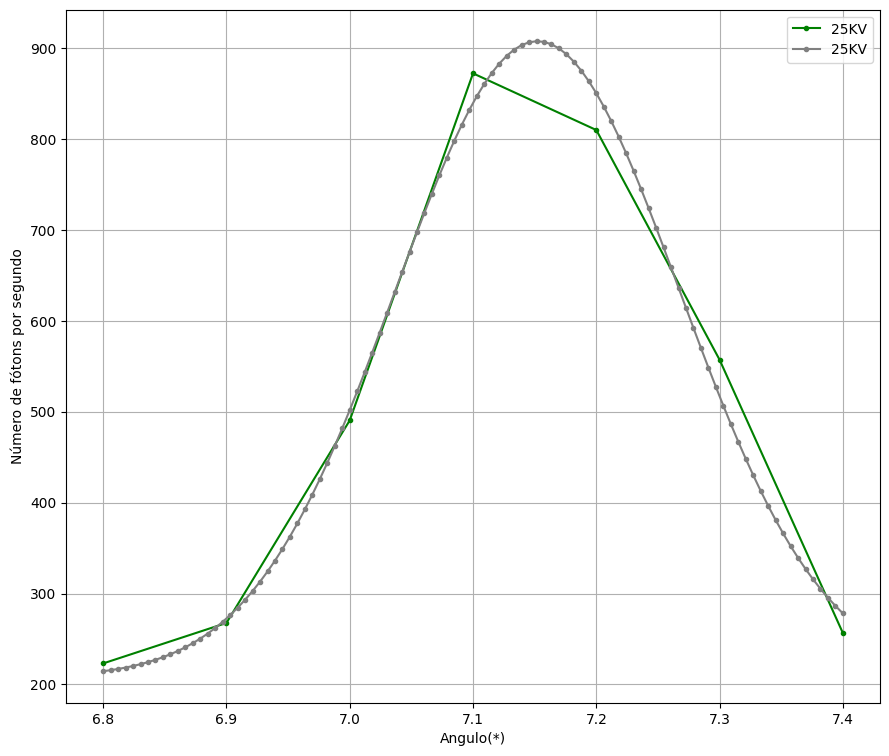

Para o pico Beta : 
 a =  0.013563516904435052 
 b =  6.348525164246888 
 N =  227.38736393082033 
 c =  224.23379866311538 
 Matriz de covariancia : 
 [[ 3.19038572e-06  1.38452888e-07  8.02209709e-04 -1.09138713e-02]
 [ 1.38452888e-07  2.63609548e-05  1.39473686e-03 -1.23773961e-03]
 [ 8.02209709e-04  1.39473686e-03  1.18747783e+02 -4.17988427e+01]
 [-1.09138713e-02 -1.23773961e-03 -4.17988427e+01  6.30431044e+01]] 
 Ajuste do pico beta já considerando incertezas :


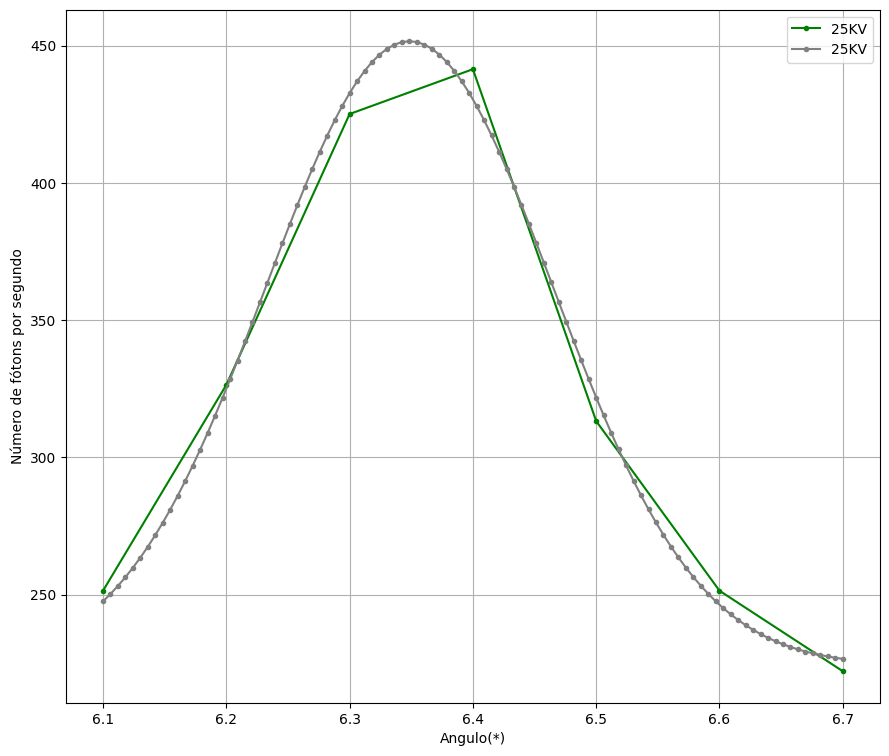

Razão [2.00935211143263, 0.11910352059362972]


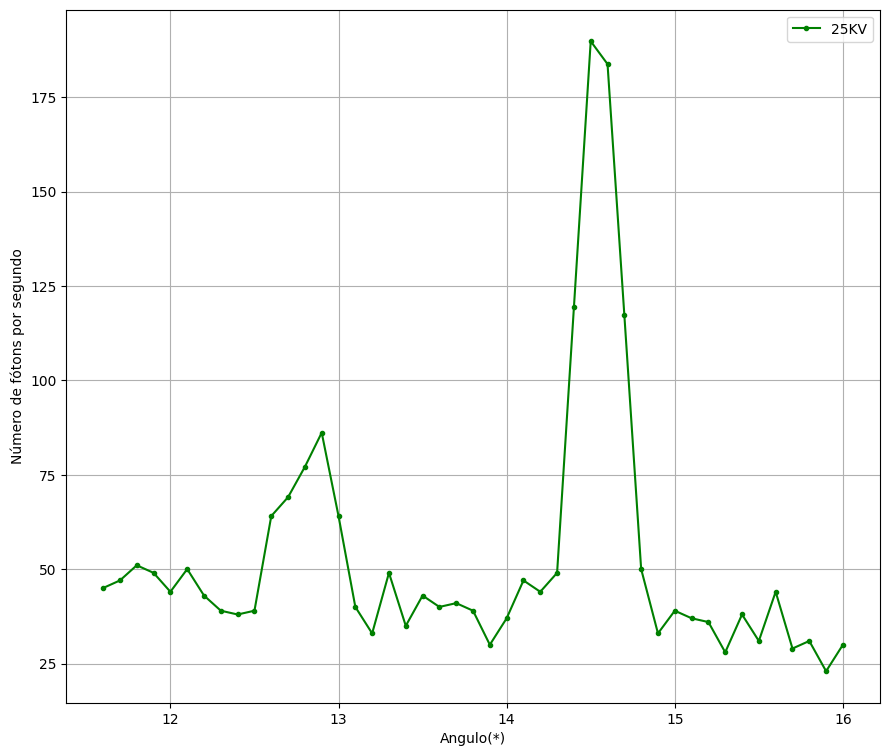

Para o pico alfa : 
 a =  0.013732175683045965 
 b =  14.548522813682396 
 N =  167.17997632827516 
 c =  37.42256000812161 
 Matriz de covariancia : 
 [[ 5.13805167e-06 -3.23792087e-07 -2.33759081e-03 -1.12930573e-02]
 [-3.23792087e-07  4.82446513e-05 -2.74353242e-03  2.51623830e-03]
 [-2.33759081e-03 -2.74353242e-03  1.12592792e+02 -2.17973115e+01]
 [-1.12930573e-02  2.51623830e-03 -2.17973115e+01  4.09039842e+01]] 
 Ajuste do pico alfa já considerando incertezas :


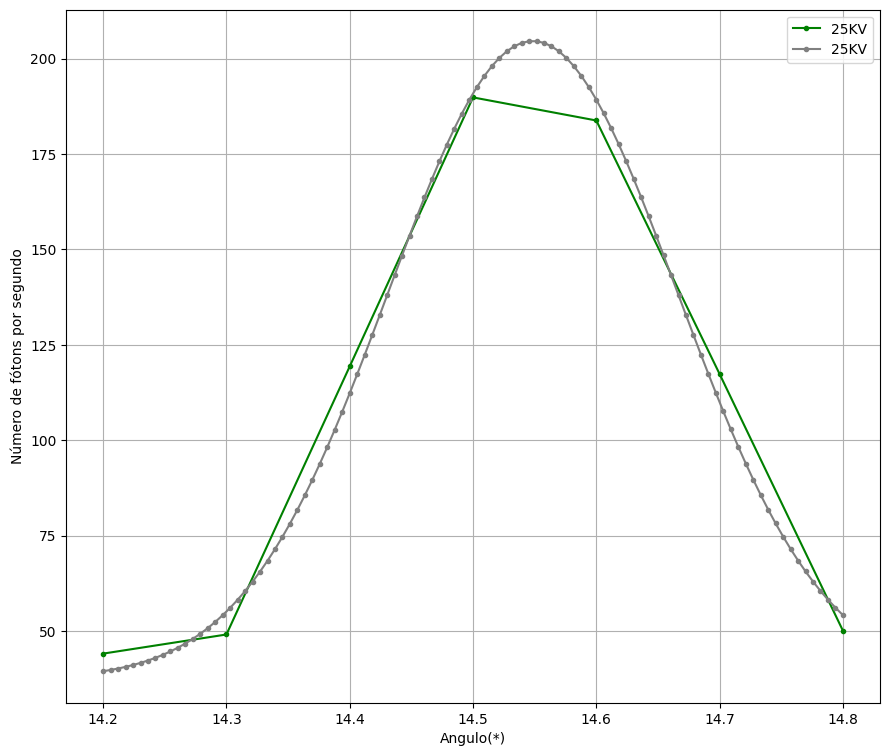

Para o pico Beta : 
 a =  0.04834731687481892 
 b =  12.808373811840537 
 N =  63.11330128080698 
 c =  18.764790607628832 
 Matriz de covariancia : 
 [[ 1.34416514e-03 -1.15193020e-05  6.76878547e-01 -8.14696723e-01]
 [-1.15193020e-05  6.29821176e-04  1.15414410e-01 -9.59847510e-02]
 [ 6.76878547e-01  1.15414410e-01  4.60012767e+02 -4.86256061e+02]
 [-8.14696723e-01 -9.59847510e-02 -4.86256061e+02  5.51314400e+02]] 
 Ajuste do pico beta já considerando incertezas :


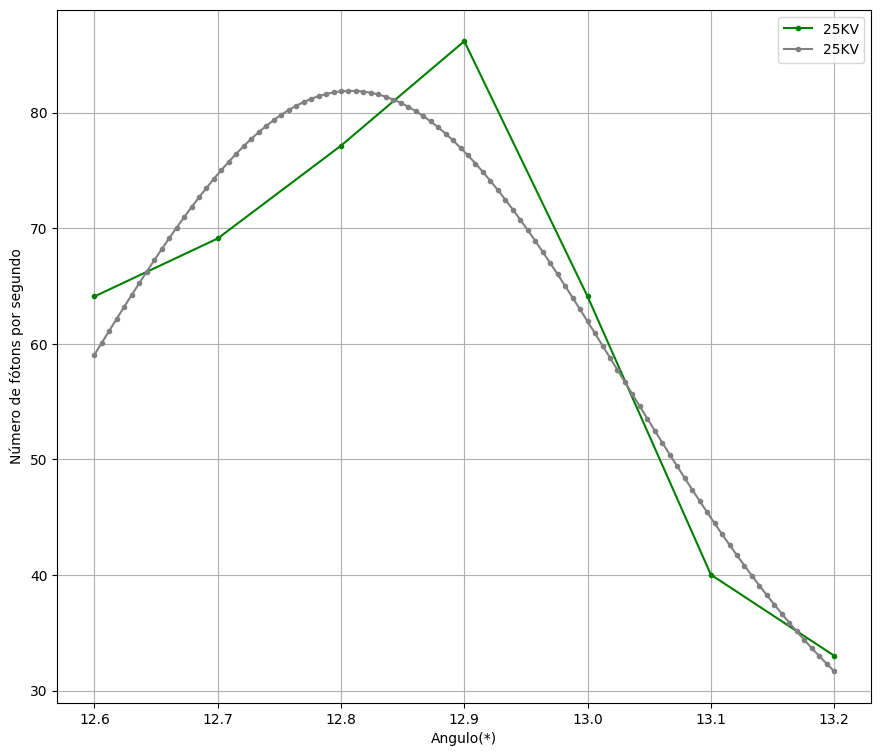

Razão [2.4988679098089013, 0.9822824183172038]


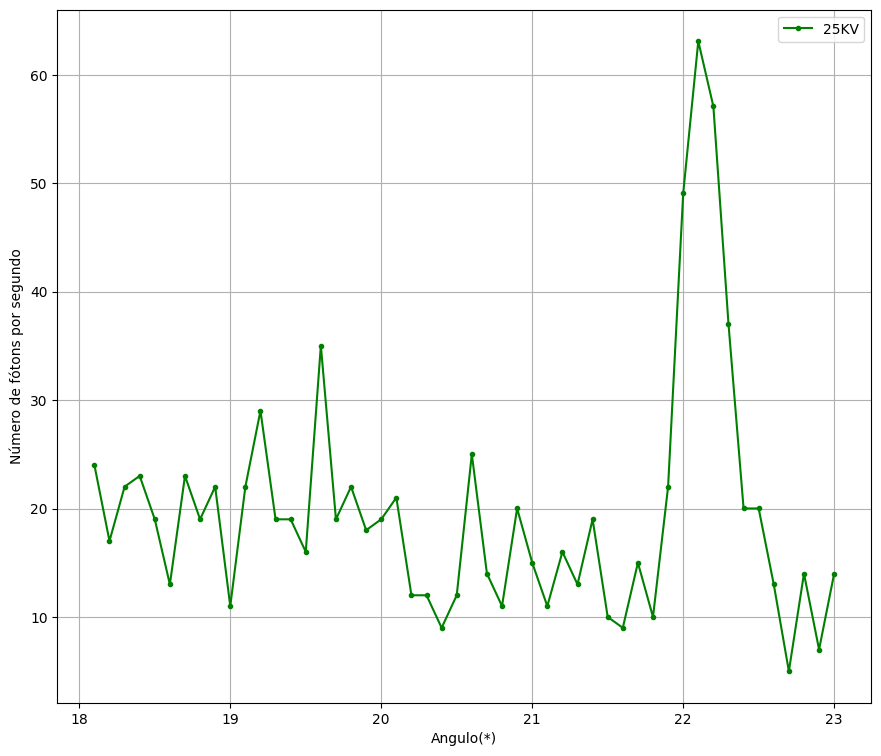

Para o pico alfa : 
 a =  0.02485436964213146 
 b =  22.134074650225887 
 N =  60.10465791665525 
 c =  3.8023447958245904 
 Matriz de covariancia : 
 [[ 2.05481665e-05 -4.37558855e-06  8.98215833e-03 -1.64040655e-02]
 [-4.37558855e-06  3.50609425e-05 -4.88835897e-03  5.37178565e-03]
 [ 8.98215833e-03 -4.88835897e-03  1.34791684e+01 -1.06629442e+01]
 [-1.64040655e-02  5.37178565e-03 -1.06629442e+01  1.51467635e+01]] 
 Ajuste do pico alfa já considerando incertezas :


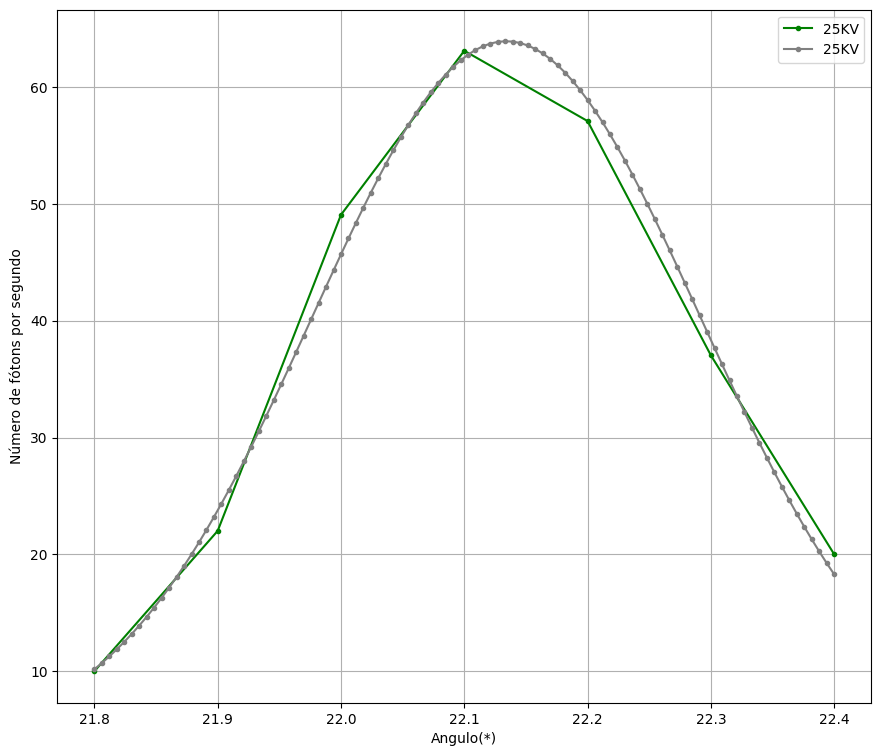

Para o pico Beta : 
 a =  0.0002073798606813408 
 b =  19.600710616792657 
 N =  16.367363434317387 
 c =  18.68052659690971 
 Matriz de covariancia : 
 [[ 1.23675462e+09 -1.32538735e+11 -7.55380740e+12 -2.61509476e+04]
 [-1.32538735e+11  5.02245307e+13  2.83016097e+15  2.00581311e+06]
 [-7.55380740e+12  2.83016097e+15  1.59488248e+17  1.15032029e+08]
 [-2.61509476e+04  2.00581311e+06  1.15032029e+08  1.59976865e+00]] 
 Ajuste do pico beta já considerando incertezas :


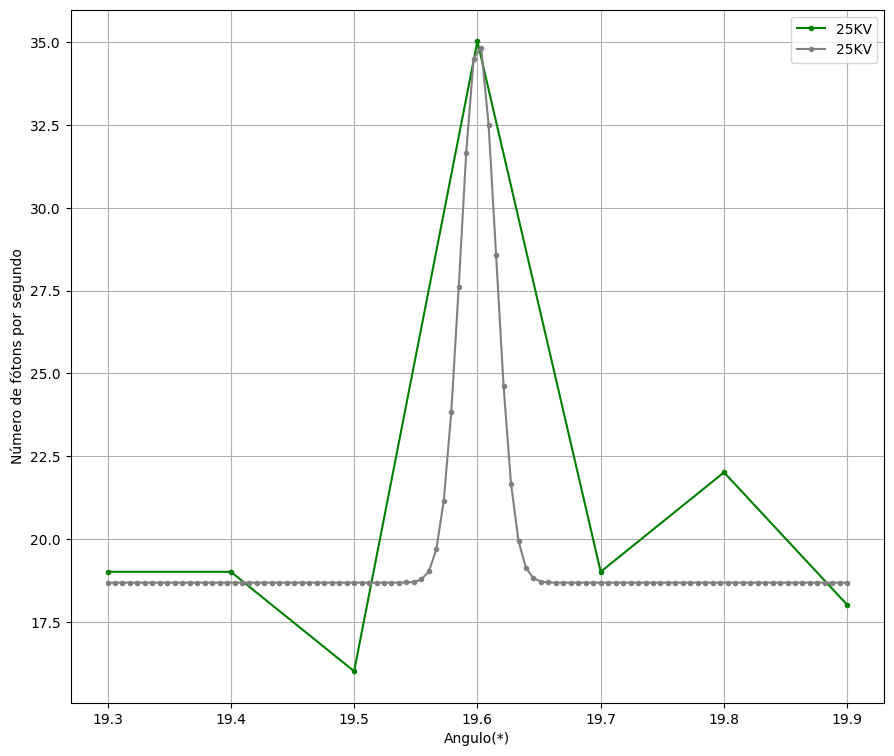

Razão [1.8234194028667559, 20777296.52985678]


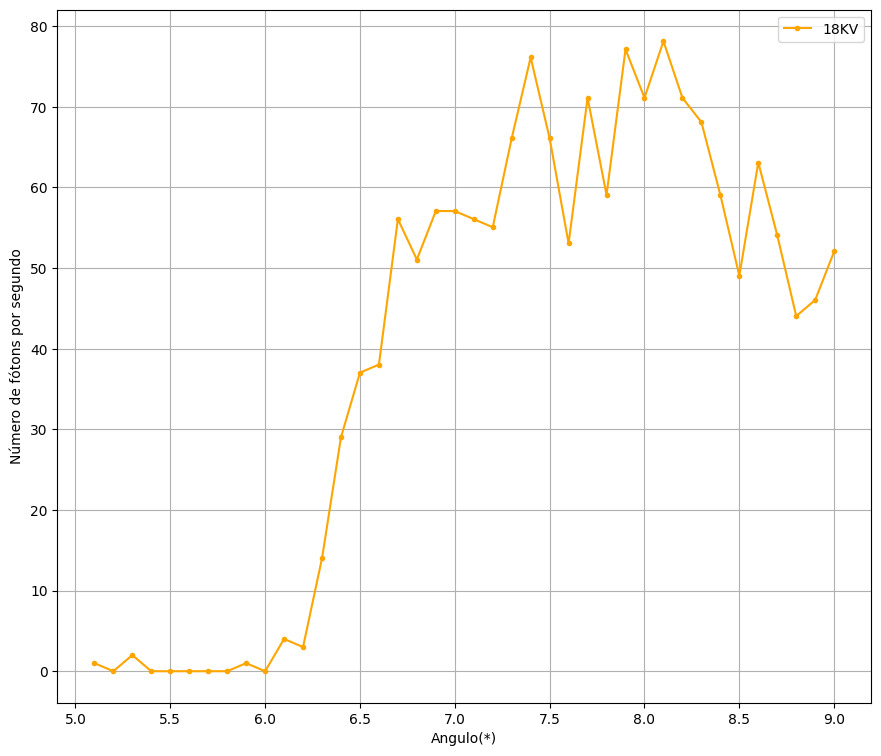

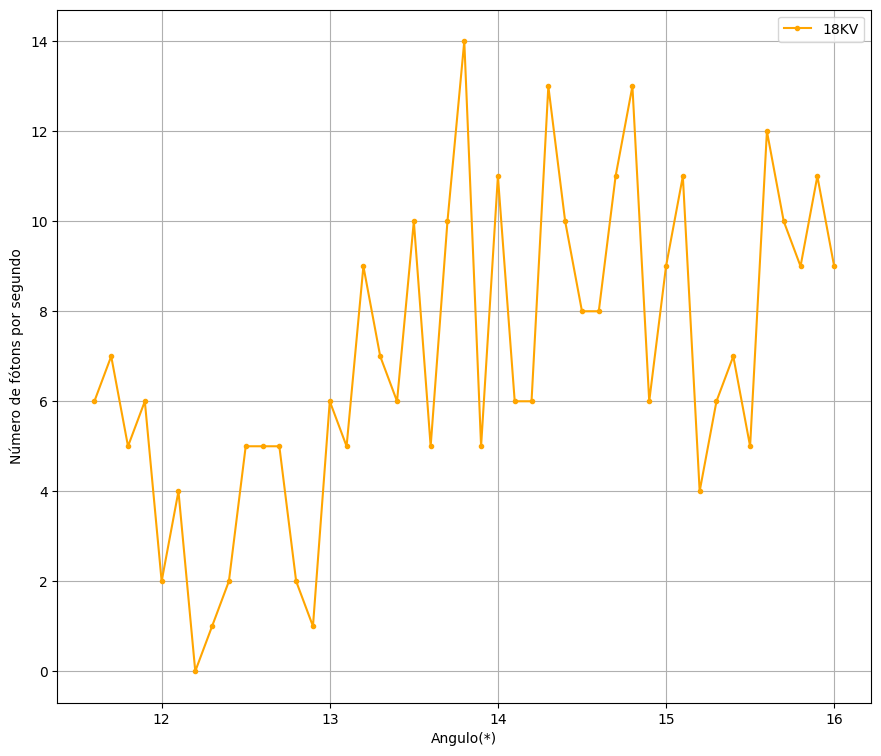

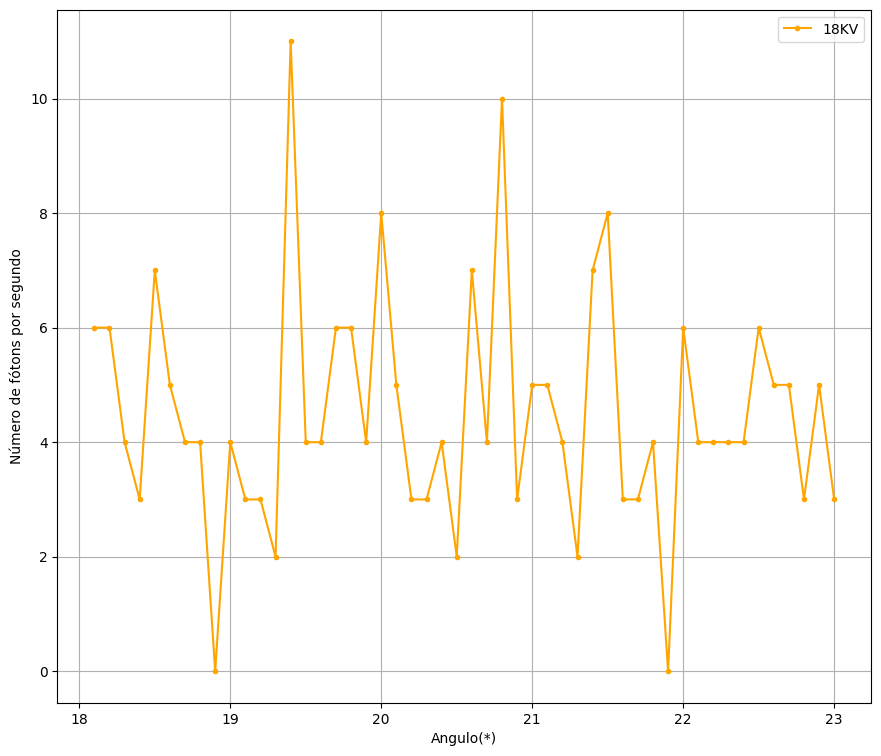

In [349]:
cores = ['Blue', 'Red', 'Yellow', 'Green', 'Orange']
voltagens =['35KV', '30KV', '28KV', '25KV', '18KV']
grafs = ['B', 'C', 'D', 'E', 'F']
def AnalisePicos(cor, voltagem, graf):
    
    def gauss(x, a, b, N, c):
        return c + N*np.exp((-(x-b)**2/(2*a)))


    for w in range(3):
        selecANG =[]
        selecTaxaMedidaNF = []
        for i in range(0, 275):
            if df['A'][i] >= 5.01 + 6.5*w  and df['A'][i] <= 9 + 7*w :
                selecANG.append(df['A'][i])
                selecTaxaMedidaNF.append(df[graf][i])
        
        selecNF = []
        for i in range(len(selecTaxaMedidaNF)):
            selecNF = selecNF + [selecTaxaMedidaNF[i]/(1-TempoMorto*selecTaxaMedidaNF[i])]

        plt.figure    (figsize=(10.5, 9))
        plt.plot(selecANG, selecNF, label=voltagem, marker='.', color=cor )
        plt.xlabel('Angulo(*)')
        plt.ylabel('Número de fótons por segundo')
        plt.grid()
        plt.legend()
        plt.show()
        
        
        if cor != 'Orange':
            
            #calculo dos I_alfa e I_beta
            ListaOrdenadasPico1 = [] #lista das ordenadas dos pontos proximos ao pico 1
            ListaAbsPico1 = [] #lista das abissiças dos pontos proximos ao pico 1
            Npico1 = 0 #Posição (ou indice) das coordenadas do pico 1 nas lista selecANG e selecNF
            
            ListaOrdenadasPico2 = [] #lista das ordenadas dos pontos proximos ao pico 2
            ListaAbsPico2 = [] #lista das abissiças dos pontos proximos ao pico 2
            
            selecNFtiraPico1 = copy.deepcopy(selecNF)
            selecANGtiraPico1 = copy.deepcopy(selecANG)
            
            
            "Dangulo = 0.005"
            
            for i in range(len(selecNF)):
                if selecNF[i]==max(selecNF):
                    Npico1 = i
            for i in range(7):
                ListaOrdenadasPico1 = ListaOrdenadasPico1 + [selecNF[Npico1-3+i]]
                ListaAbsPico1 = ListaAbsPico1 + [selecANG[Npico1-3+i]]
                del selecNFtiraPico1[Npico1-3]
                del selecANGtiraPico1[Npico1-3]


            for i in range(len(selecNFtiraPico1)):
                if selecNFtiraPico1[i]==max(selecNFtiraPico1):
                    Npico2 = i
            for i in range(7):
                ListaOrdenadasPico2 = ListaOrdenadasPico2 + [selecNFtiraPico1[Npico2-3+i]]
                ListaAbsPico2 = ListaAbsPico2 + [selecANGtiraPico1[Npico2-3+i]]

            #def LigaGrafico(x, x1, y1, x2, y2):
                #return(x*(y1-y2)/(x1-x2) + (x1*y2-x2*y1)/(x1-x2))



            #Calculo das incertezas:
            ListaSigmaOrdPico1 = []
            ListaSigmaOrdPico2 = []
            
            for i in range(len(ListaOrdenadasPico1)):
                TaxaMedidaPico1 = ListaOrdenadasPico1[i]/(ListaOrdenadasPico1[i]*TempoMorto + 1)
                if len(ListaOrdenadasPico2)-1 > i > 0:
                    dF1dx = (ListaOrdenadasPico1[i+1] - ListaOrdenadasPico1[i-1])/0.2
                elif i == 0:
                    dF1dx = (ListaOrdenadasPico1[1] - selecNF[Npico1-4])/0.2
                else:
                    dF2dx = (selecNF[Npico1+4] - ListaOrdenadasPico1[i-1])/0.2
                ListaSigmaOrdPico1 = ListaSigmaOrdPico1 + [((TaxaMedidaPico1**(1/2)/(TaxaMedidaPico1*TempoMorto-1)**2)**2 + (SigmaTMorto*TaxaMedidaPico1**2/(TempoMorto*TaxaMedidaPico1-1)**2)**2 + (dF1dx*0.005)**2)**(1/2)]
            
            for i in range(len(ListaOrdenadasPico2)):
                TaxaMedidaPico2 = ListaOrdenadasPico2[i]/(ListaOrdenadasPico2[i]*TempoMorto + 1)
                if len(ListaOrdenadasPico2)-1 > i > 0:
                    dF2dx = (ListaOrdenadasPico2[i+1] - ListaOrdenadasPico2[i-1])/0.2
                elif i == 0:
                    dF2dx = (ListaOrdenadasPico2[1] - selecNF[Npico2-4])/0.2
                else:
                    dF2dx = (selecNF[Npico2+4] - ListaOrdenadasPico2[i-1])/0.2
                ListaSigmaOrdPico2 = ListaSigmaOrdPico2 + [((TaxaMedidaPico2**(1/2)/(TaxaMedidaPico2*TempoMorto-1)**2)**2 + (SigmaTMorto*TaxaMedidaPico2**2/(TempoMorto*TaxaMedidaPico2-1)**2)**2 + (dF2dx*0.005)**2)**(1/2)]
                

            poptP1, pcovP1 = curve_fit(gauss, ListaAbsPico1, ListaOrdenadasPico1, bounds=([0, ListaAbsPico1[1], 0, 0], [10, ListaAbsPico1[5], 3000, 300]), sigma=ListaSigmaOrdPico1 ) #a, b, N, c
            poptP2, pcovP2 = curve_fit(gauss, ListaAbsPico2, ListaOrdenadasPico2, bounds=([0, ListaAbsPico2[1], 0, 0], [10, ListaAbsPico2[5], 1500, 300]), sigma=ListaSigmaOrdPico2 ) #a, b, N, c
            
            print('Para o pico alfa : \n','a = ', poptP1[0], '\n','b = ', poptP1[1], '\n', 'N = ', poptP1[2], '\n', 'c = ', poptP1[3], '\n', 'Matriz de covariancia : \n', pcovP1, '\n', 'Ajuste do pico alfa já considerando incertezas :' )#a, b, N, c
            
            #poptP1 é a lista dos valores dos parametros ajustados do pico 1
            #pcovP1 é a matriz de covariancia. As incertezas são as raizesdos elementos da diagonal principal
            
            rgBL = np.linspace(ListaAbsPico1[0], ListaAbsPico1[6], num = 100) #rgBL é um range continuo (100 pontos) entre 6.9 e 7.5

            plt.figure(figsize=(10.5, 9))
            plt.plot(ListaAbsPico1, ListaOrdenadasPico1, label=voltagem, marker='.', color=cor )
            plt.plot(rgBL, gauss(rgBL, *poptP1), label=voltagem, marker='.', color='gray' )
            plt.xlabel('Angulo(*)')
            plt.ylabel('Número de fótons por segundo')
            plt.grid()
            plt.legend()
            plt.show()
            
            
            
            print('Para o pico Beta : \n','a = ', poptP2[0], '\n','b = ', poptP2[1], '\n', 'N = ', poptP2[2], '\n', 'c = ', poptP2[3], '\n', 'Matriz de covariancia : \n', pcovP2, '\n', 'Ajuste do pico beta já considerando incertezas :' )
            
            #poptP1 é a lista dos valores dos parametros ajustados do pico 1
            #pcovP1 é a matriz de covariancia. As incertezas são as raizesdos elementos da diagonal principal
            
            rgBL = np.linspace(ListaAbsPico2[0], ListaAbsPico2[6], num = 100) #rgBL é um range continuo (100 pontos) entre 6.9 e 7.5

            plt.figure(figsize=(10.5, 9))
            plt.plot(ListaAbsPico2, ListaOrdenadasPico2, label=voltagem, marker='.', color=cor )
            plt.plot(rgBL, gauss(rgBL, *poptP2), label=voltagem, marker='.', color='gray' )
            plt.xlabel('Angulo(*)')
            plt.ylabel('Número de fótons por segundo')
            plt.grid()
            plt.legend()
            plt.show()

            
            RazãoIKaIKb = [(poptP1[2]+poptP1[3])/(poptP2[2]+poptP2[3]), ((1/(poptP2[2]+poptP2[3]) * pcovP1[2][2]**(1/2))**2 + (1/(poptP2[2]+poptP2[3]) * pcovP1[3][3]**(1/2))**2 + ((poptP1[2]+poptP1[3])/(poptP2[2]+poptP2[3])**2 * pcovP2[2][2]**(1/2))**2 + ((poptP1[2]+poptP1[3])/(poptP2[2]+poptP2[3])**2 * pcovP2[3][3]**(1/2))**2)**(1/2)]
            print('Razão', RazãoIKaIKb)
            # Ajuste primitivo
    




for j in range(0, 5):
    AnalisePicos(cor=cores[j], voltagem=voltagens[j], graf=grafs[j])
    



# Cálculo da <font color='#7ac77a'>constante de Planck</font> 
--------------------------------------------
Para isso vamos fazer o seguinte procedimento: 
- 1) vamos pegar os primeiros valores do gráfico de angulos
- 2) passar os dádos para comprimento de onda
- 3) ajusta-los com a função do Breinstrung que vamos obter do multiplot 
- 4) usar essa relação para achar h
----------------------

[3.046477975368915, 3.5607049575858323, 3.8780720067226664, 4.299995661900022] [0.48965350989330686, 0.5154276603293699, 0.8417478235406577, 1.1650422533120706]
Comprimento de onda para 35000 É igual a :  2.9974355799853054e-11
Comprimento de onda para 30000 É igual a :  3.502780107267625e-11
Comprimento de onda para 28000 É igual a :  3.81452693392035e-11
Comprimento de onda para 25000 É igual a :  4.228795934748316e-11


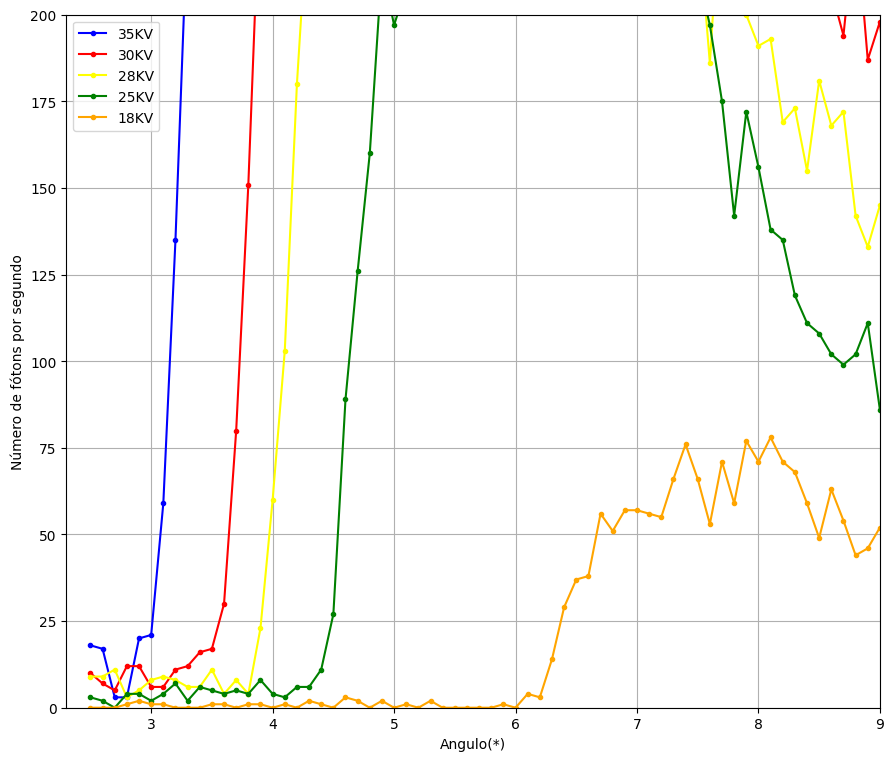

a = 1.053929417728273e-06  
 Incerteza do parâmetro a : 
 3.940922679312019e-09
h = 5.632500224436815e-34  
 Incerteza de h : 
 2.106141787327549e-36


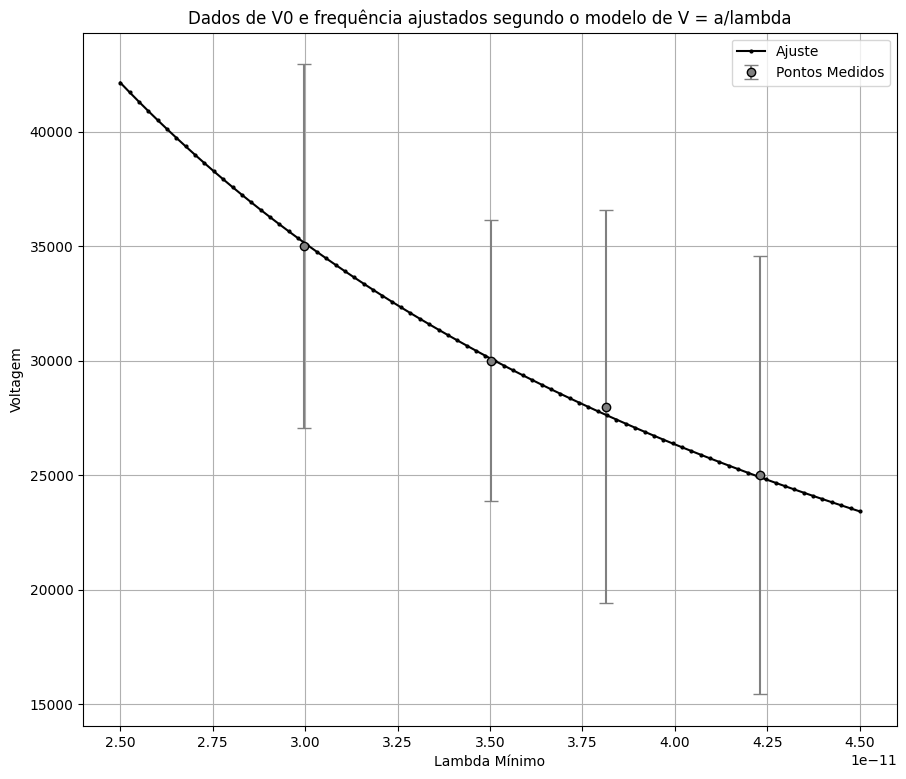

[350, 300, 280, 250]
[7955.820884084422, 6140.832517348118, 8586.304500446282, 9564.463923775722]


In [350]:
def Linear(x, a, b):
    return(a*x+b)

AngsMin = []
SigmaAngsMin = []

Angulos = []
Contagens = []



for i in range(4):
    for j in range(275):
        Angulos = Angulos + [df['A'][j]]
        Contagens = Contagens + [df[grafs[i]][j]]
    
    Contagens = df[grafs[i]]
    for j in range(50):
        if Contagens[j] >= 30:
            InicioDoAjuste = j
            break
    SelecAngLinear = []
    SelecNFLinear = []
    SigmaSelecAngLinear = []
    SigmaSelecNFLinear = []
    
    for k in range(5):
        
        SelecAngLinear.append(Angulos[InicioDoAjuste + k])
        #SelecAngLinear = SelecAngLinear + [Angulos[InicioDoAjuste + k]]
        SelecNFLinear = SelecNFLinear + [Contagens[InicioDoAjuste + k]]
        SigmaSelecNFLinear = SigmaSelecNFLinear + [((Contagens[InicioDoAjuste + k]) + (((Contagens[InicioDoAjuste + 1] - Contagens[InicioDoAjuste])/0.1)*0.005)**2)**(1/2)]
    poptLb, pcovLb = curve_fit(Linear, SelecAngLinear, SelecNFLinear, sigma=SigmaSelecNFLinear)
    
    AngsMin = AngsMin + [-poptLb[1]/poptLb[0]]
    SigmaAngsMin = SigmaAngsMin + [((pcovLb[0][0]**(1/2)*poptLb[1]/poptLb[0]**2)**2 + (pcovLb[1][1]**(1/2)/poptLb[0]))**(1/2)]
    
        
print(AngsMin, SigmaAngsMin)

# Zoom no inicio do multiplot 
def zoom(xlmin, xlmax, ylmin, ylmax):
    plt.figure(figsize=(10.5, 9))
    plt.plot(df['A'], df['B'], label='35KV', marker='.', color='Blue')
    plt.plot(df['A'], df['C'], label='30KV', marker='.', color='Red')
    plt.plot(df['A'], df['D'], label='28KV', marker='.', color='Yellow')
    plt.plot(df['A'], df['E'], label='25KV', marker='.', color='Green')
    plt.plot(df['A'], df['F'], label='18KV', marker='.', color='Orange')
    plt.xlabel('Angulo(*)')
    plt.ylabel('Número de fótons por segundo')
    plt.xlim(xlmin, xlmax)
    plt.ylim(ylmin, ylmax)
    plt.grid()
    plt.legend()
    plt.show()
    
def Tensão(x, a):
    return  a/x

# Achar o Lambda mínimo 
def Bragg(AngMin):
    d = 0.282e-9
    #n = 1 
    # Retorna o lambda mínimo
    return 2*d*math.sin(AngMin)

def hgenerator2():
    e = -1.602176634e-19 # C
    # a = hc/e
    c = 299792458 # m/s
    h = -poptfin[0]*e/c
    sigma_h = -sig_a*e/c
    return h, sigma_h

def sigma_ldmin(theta, delta_theta):
    # Convertendo ângulos para radianos
    theta_rad = np.radians(theta)
    delta_theta_rad = np.radians(delta_theta)
    
    # Calculando a incerteza em lambda_min
    delta_lambda = np.sqrt((2 * 0.282e-9 * np.cos(theta_rad) * delta_theta_rad)**2 + 
                           ((2 * 0.282e-9) * np.cos(theta_rad) * delta_theta_rad)**2)
    
    return delta_lambda    

SigmaLambdasMin = [] 
for i in range(4):
    SigmaLambdasMin = SigmaLambdasMin + [sigma_ldmin(AngsMin[i], SigmaAngsMin[i])]

voltagens = [35000, 30000, 28000, 25000] # V
sigmaV = [350, 300, 280, 250] # Sigma voltz em V
#AngsMin =[3.75, 4.5, 5.25, 5.75]  Teta mínimo da Ivy
lambdas = []

SigmaFin =[]

for i in range(0, len(AngsMin)):
    lamb = Bragg(math.radians(AngsMin[i]))
    lambdas.append(lamb)
    print('Comprimento de onda para', str(voltagens[i]), 'É igual a : ', lamb)
    SigmaFin = SigmaFin + [((sigmaV[i])**2 + (SigmaLambdasMin[i]*voltagens[i]/lambdas[i])**2)**(1/2)]

poptfin, pcovfin = curve_fit(Tensão, lambdas, voltagens, sigma=SigmaFin)

sig_a = math.sqrt(pcovfin[0][0])

zoom(2.3, 9, 0, 200)
print('a =', poptfin[0], ' \n Incerteza do parâmetro a : \n', sig_a )
h, sigma_h = hgenerator2()
print('h =', h, ' \n Incerteza de h : \n', sigma_h )


dataPlotx = np.linspace(2.5*10**(-11), 4.5*10**(-11), 80)
plt.figure(figsize=(10.5, 9)) # Inputs lambdas, output tensões. Ajuste V = a/lambda
plt.errorbar(lambdas, voltagens, yerr=SigmaFin, fmt = 'o', markerfacecolor = 'gray', markeredgecolor = 'black', ecolor='gray', capsize= 5, label = 'Pontos Medidos')
plt.plot(dataPlotx, Tensão(dataPlotx, *poptfin), marker ='.', label = 'Ajuste', color = 'black', markersize = '4' )
plt.title('Dados de V0 e frequência ajustados segundo o modelo de V = a/lambda')
plt.xlabel('Lambda Mínimo')
plt.ylabel('Voltagem')
plt.legend()
plt.grid()
plt.show()

print(sigmaV)
print(SigmaFin)

Análise da Absortância dos Materiais

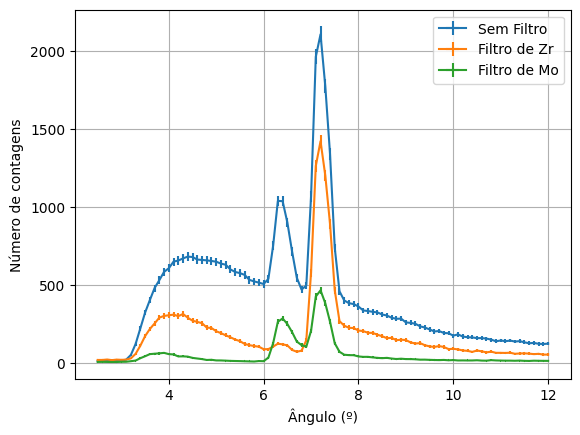

0     0.231738
1     0.225410
2     0.203471
3     0.287823
4     0.214241
        ...   
91    0.329377
92    0.358584
93    0.330472
94    0.367652
95    0.371921
Name: M, Length: 96, dtype: float64
0     0.809333
1     0.724128
2     0.839890
3     1.056565
4     0.908878
        ...   
91    2.613409
92    2.287670
93    2.322574
94    2.393020
95    2.462417
Name: N, Length: 96, dtype: float64


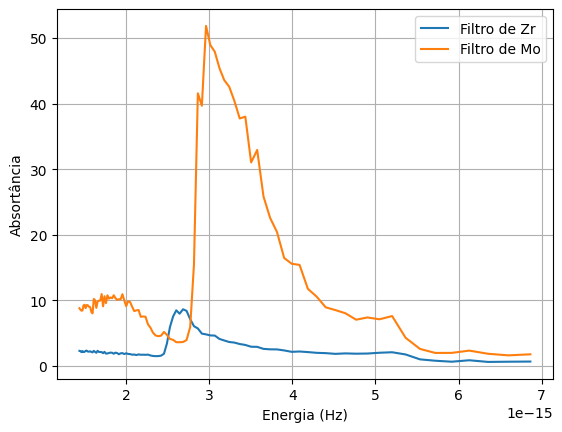

In [357]:
# Criando novas colunas com as incertezas dos valores, incluindo a correção do tempo morto.
abs['E'] = 0.005
abs['F'] = np.sqrt((np.sqrt(abs['B'])/(1-abs['B']*poptTM2[1])**2)**2 + (((abs['B']*poptTM2[1])/(1-abs['B']*poptTM2[1])**2)*np.sqrt(pcovTM2[1][1]))**2)
abs['G'] = np.sqrt((np.sqrt(abs['C'])/(1-abs['C']*poptTM2[1])**2)**2 + (((abs['C']*poptTM2[1])/(1-abs['C']*poptTM2[1])**2)*np.sqrt(pcovTM2[1][1]))**2)
abs['H'] = np.sqrt((np.sqrt(abs['D'])/(1-abs['D']*poptTM2[1])**2)**2 + (((abs['D']*poptTM2[1])/(1-abs['D']*poptTM2[1])**2)*np.sqrt(pcovTM2[1][1]))**2)
abs['B'] = abs['B']/(1-(pcovTM2[1][1]*abs['B']))
abs['C'] = abs['C']/(1-(pcovTM2[1][1]*abs['C']))
abs['D'] = abs['D']/(1-(pcovTM2[1][1]*abs['D']))

# Criando nova coluna no dataframe da absortância que coloca a energia correspondente a cada ângulo, usando o valor de h obtido anteriormente. Também criar a coluna da respectiva incerteza.
abs['I'] = (h*299792458)/(2*0.282e-9*np.sin(abs['A']*math.pi/180))
abs['J'] = np.sqrt((299792458*sigma_h/(2*0.282e-9*np.sin(abs['A']*math.pi/180)))**2 + (h*299792458*np.cos(abs['A']*math.pi/180)*abs['E']/(2*0.282e-9*np.sin(abs['A']*math.pi/180))**2)**2)

# Plotando Contagem de Fótons/Segundo em função do Ângulo
plt.errorbar(abs['A'], abs['B'], abs['F'], abs['E'], label='Sem Filtro')
plt.errorbar(abs['A'], abs['C'], abs['G'], abs['E'], label='Filtro de Zr')
plt.errorbar(abs['A'], abs['D'], abs['H'], abs['E'], label='Filtro de Mo')
plt.xlabel('Ângulo (º)')
plt.ylabel('Número de contagens')
plt.grid()
plt.legend()
plt.show()

# Calculando a absortância para o Zr e o Mo, bem como suas incertezas
abs['K'] = abs['B']/abs['C']
abs['L'] = abs['B']/abs['D']
abs['M'] = np.sqrt((abs['F']/abs['C'])**2 + (abs['B']*abs['G']/(abs['C'])**2)**2)
abs['N'] = np.sqrt((abs['F']/abs['D'])**2 + (abs['B']*abs['H']/(abs['D'])**2)**2)

print(abs['M'])
print(abs['N'])
# Plotando a absortância em função da energia para o Zr e o Mo
# plt.errorbar(abs['I'], abs['K'], abs['M'], 0, label='Filtro de Zr')
# plt.errorbar(abs['I'], abs['L'], abs['N'], 0, label='Filtro de Mo')
plt.plot(abs['I'], abs['K'], label='Filtro de Zr')
plt.plot(abs['I'], abs['L'], label='Filtro de Mo')
plt.xlabel('Energia (Hz)')
plt.ylabel('Absortância')
plt.grid()
plt.legend()
plt.show()

# Usando a lei de Lambert-Beer para obter a espessura do absorvedor
